# Imports

In [1]:
# Librairies
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as st
from scipy.special import boxcox1p
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel

In [2]:
# Seaborn
sns.set() # Seaborn avec plt.
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,6)})
sns.set_palette('Set3')

In [3]:
# Styles
class style:
   blue = '\033[94m'
   green = '\033[92m'
   red = '\033[91m'
   bold = '\033[1m'
   underline = '\033[4m'
   end = '\033[0m' 

In [4]:
# Fonction indicateurs univariés
def indicateurs(df, variable):
    
    # Paramètres de position
    mode = df[variable].mode().to_list()
    frequence_mode = round((len(df[df[variable]==mode[0]]) / len(df) * 100), 1)
    moyenne = round(df[variable].mean(), 1)
    mediane = df[variable].median()
    quartile_1 = round(df[variable].quantile(0.25), 1)
    quartile_3 = round(df[variable].quantile(0.75), 1)
      
    # Paramètres de dispersion
    minimum = df[variable].min()
    maximum = df[variable].max()
    etendue = round((maximum - minimum), 1)
    variance = round(df[variable].var(ddof=0), 1)
    ecart_type = round(df[variable].std(ddof=0), 1)
    coeff_variation = round(df[variable].std(ddof=0) / df[variable].mean(), 1)
    
    skewness = round(df[variable].skew(), 1)
    if skewness > 0:
        skewness_symetrie = 'étalée à droite'
    elif skewness < 0:
        skewness_symetrie = 'étalée à gauche'
    else:
        skewness_symetrie = 'symétrique'
        
    kurtosis = round(df[variable].kurtosis(), 1)
    if kurtosis > 0:
        kurtosis_aplatissement = 'moins aplatie que la normale gaussienne'
    elif kurtosis < 0:
        kurtosis_aplatissement = 'plus aplatie que la normale gaussienne'
    else:
        kurtosis_aplatissement = 'normale (gaussienne)'
        
    # Affichage
    print(
        style.bold + 'Indicateurs de position :' + style.end,
        '\nMode(s) :', mode, '(fréquence :', frequence_mode, '%)',        
        '\nMoyenne :', moyenne, '\nMédiane :', mediane,
        '\n1er quartile :', quartile_1, '\n3ème quartile :', quartile_3,
        
        style.bold + '\nIndicateurs de dispersion :' + style.end,
        '\nMinimum :', minimum, '\nMaximum :', maximum, '\nÉtendue :', etendue,
        '\nVariance :', variance, '\nÉcart-type : ', ecart_type,
        '\nCoeff. de variation :', coeff_variation,
        '\nSkewness :', skewness, '( distribution', skewness_symetrie, ')',
        '\nKurtosis :', kurtosis, '( distribution', kurtosis_aplatissement, ')')

In [5]:
# Fonction indicateurs bivariés
def indicateurs_bivaries(df, variable_1, variable_2):
    for mode in df[variable_1].unique():
        subset = df[df[variable_1] == mode]
        print(
            style.bold + style.blue + 'Modalité :' + style.end, mode,
            '(fréquence :', round((len(subset) / len(df) * 100), 1), '%)\n'
        ),
        indicateurs(subset, variable_2), 
        print('\n')

# Données

## Collecte
3 datasets : 
- **clients** (3 variables : identidiant, sexe et année de naissance du client)
- **produits** (3 variables : identifiant, prix et catégorie du produit)
- **transactions** (4 variables : identifiants du produit, du client, de la session, et la date de transaction)

💡 **transactions** partage un nom de variable avec chaque dataset (*id_prod* et *client_id*)

In [6]:
# URL
url = 'https://raw.githubusercontent.com/gllmfrnr/oc/master/p4/sources/'
url = 'sources/'

# Dataframes
clients = pd.read_csv(url + 'customers.csv')
produits = pd.read_csv(url + 'products.csv')    
transactions = pd.read_csv(url + 'transactions.csv')

In [7]:
print('Dataframe', style.bold + 'clients' + style.end)
clients.sample(3)

Dataframe clients


,client_id,sex,birth
7876,c_596,m,2002
7885,c_4626,m,1991
1125,c_7744,m,1997


In [8]:
print('Dataframe', style.bold + 'produits' + style.end)
produits.sample(3)

Dataframe produits


,id_prod,price,categ
2983,1_637,32.99,1
2307,0_1541,11.99,0
2586,0_458,6.75,0


In [9]:
print('Dataframe', style.bold + 'transactions' + style.end)
transactions.sample(3)

Dataframe transactions


,id_prod,date,session_id,client_id
50882,0_1507,2021-04-14 19:46:12.306370,s_20586,c_7929
212527,0_1391,2021-11-28 21:42:09.512676,s_126513,c_159
123784,0_1173,2021-03-04 02:25:49.498064,s_1423,c_4831


## Variables
- Nouveaux noms de variable capitalisés en français (visualisations plus propres)

In [10]:
# Nouveaux noms de variables
clients.columns = ['client_id', 'Sexe', 'Naissance']
produits.columns = ['id_prod', 'Prix', 'Catégorie']
transactions.columns = ['id_prod', 'Date', 'session_id', 'client_id']

# Affichage
print(clients.sample(), '\n\n', produits.sample())

     client_id Sexe  Naissance
5283    c_2880    f       2002 

     id_prod   Prix  Catégorie
782  0_2014  21.23          0


In [11]:
# Colonne indiquant l'âge du client
year = datetime.now().year
clients['Âge'] = year - clients['Naissance']
clients.sample(3)

,client_id,Sexe,Naissance,Âge
7963,c_1902,f,1970,50
4659,c_6295,f,1988,32
3692,c_4344,m,1968,52


## Duplicats
- suppression des duplicats, pour pouvoir définir les clés primaires avant l'exploration

💡 **transactions** contient des duplicats (supprimés)

In [12]:
# Fonction de vérification et suppression des duplicats
def check_duplicates(df):
    print(  
        # Vérifier la présence de duplicats
        len(df), 'lignes avant suppression \n' +
        'Nombre de duplicats :', len(df) - len(df.drop_duplicates()))

    # Suppression des duplicats  
    df.drop_duplicates(inplace=True)
    print(len(df), 'lignes après suppression')

In [13]:
# Traitement des duplicats sur clients
check_duplicates(clients)

# --> Aucun duplicat

8623 lignes avant suppression 
Nombre de duplicats : 0
8623 lignes après suppression


In [14]:
# Traitement des duplicats sur produits
check_duplicates(produits)

# --> Aucun duplicat

3287 lignes avant suppression 
Nombre de duplicats : 0
3287 lignes après suppression


In [15]:
# Traitement des duplicats sur transactions
check_duplicates(transactions)

# --> 126 duplicats, supprimés

337016 lignes avant suppression 
Nombre de duplicats : 126
336890 lignes après suppression


# Exploration
- **transactions** a 2 clés étrangères : les clés primaires de **clients** et **produits**

In [16]:
# Fonction d'exploration des datasets
def exploration(df):

    # Colonnes, null-count, types d'objets
    print(style.blue + style.bold + 'Info ↓ \n' + style.end)
    print(df.info(), '\n')
    
    # Exploration des variables
    for i in range(0, len(df.columns)):
        # Nom de la variable
        print(style.blue + 'Variable', style.bold + df.columns[i], ':' + style.end)         
        print(df.iloc[:, i].describe())
        # Nombre de Nan
        print(sum(df.iloc[:, i].isna()), 'Nan')
        # Nombre de 0
        print(df.shape[0] - np.count_nonzero(df.iloc[:, i]), 'zéros')
        # Nombre de valeurs uniques
        print(len(df.iloc[:, i].unique()), 'valeurs uniques\n')

In [17]:
# Fonction de vérification de la clé primaire
def check_pk(df_pk):
  table_length = len(df_pk) - len(df_pk.drop_duplicates())
  if table_length == 0:
    print(style.bold + style.green + 'Clé primaire (0 duplicat)' + style.end)
  else:
    print(style.underline + style.red + 'Pas une clé primaire (', table_length, 'duplicats )' + style.end)

## Clients
- aucune valeur manquante ou aberrante
- *client_id* ne contient aucun doublon (indicateur d'une clé primaire)
- *Sexe* ne contient que 2 modalités : 'f' et 'm' (variable qualitative)
- *Naissance* indique l'année de naissance
- les distributions sont semblables pour les 2 modalités de *Sexe*
- la distribution des années de naissance est concentrée vers la droite, autour de 1980

💡 Clé primaire : *client_id*

🧑‍🤝‍🧑 Les deux sexes ont des effectifs semblables pour chaque année de naissance

In [18]:
exploration(clients)

# --> Aucun doublon dans client_id : probable clé primaire
# --> Aucune valeur manquante
# --> Aucune valeur aberrante
# --> Sexe ne contient que 2 modalités
# --> Naissance contient des entiers de 1929 à 2004

Info ↓ 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8623 entries, 0 to 8622
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   Sexe       8623 non-null   object
 2   Naissance  8623 non-null   int64 
 3   Âge        8623 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 336.8+ KB
None 

Variable client_id :
count       8623
unique      8623
top       c_1715
freq           1
Name: client_id, dtype: object
0 Nan
0 zéros
8623 valeurs uniques

Variable Sexe :
count     8623
unique       2
top          f
freq      4491
Name: Sexe, dtype: object
0 Nan
0 zéros
2 valeurs uniques

Variable Naissance :
count    8623.000000
mean     1978.280877
std        16.919535
min      1929.000000
25%      1966.000000
50%      1979.000000
75%      1992.000000
max      2004.000000
Name: Naissance, dtype: float64
0 Nan
0 zéros
76 valeurs uniques

Variable Âge :
count    8623.000000
mean      

In [19]:
# Vérification de la clé primaire sur clients[client_id]
check_pk(clients['client_id'])

Clé primaire (0 duplicat)


In [20]:
# Nouveaux noms de modalités pour 'Sexe'
clients['Sexe'].replace('f', 'Femme', inplace=True)
clients['Sexe'].replace('m', 'Homme', inplace=True)

clients.sample()

,client_id,Sexe,Naissance,Âge
4642,c_8048,Homme,1983,37


## Produits
- *Prix* contient des valeurs aberrantes (inférieures à 0)

- aucune valeur manquante
- aucun doublon dans *id_prod* (indicateur d'une clé primaire)
- valeurs aberrantes dans *Prix* (inférieures à 0)
- *Catégorie* ne contient que 3 modalités : 0, 1 et 2 (variable qualitative)
- distribution des prix concentrée sur la gauche 
- différences visibles de prix et de volume pour chaque modalité de *Catégorie*

💡 Clé primaire : *id_prod*

📚 Le prix est probablement corrélé à la catégorie 

In [21]:
exploration(produits)

# --> Aucun doublon dans *'id_prod'* : probable clé primaire
# --> Aucune valeur manquante
# --> Valeurs aberrantes dans Prix (valeurs négatives)
# --> Catégorie ne contient que 3 modalités : 0, 1 et 2

Info ↓ 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id_prod    3287 non-null   object 
 1   Prix       3287 non-null   float64
 2   Catégorie  3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 102.7+ KB
None 

Variable id_prod :
count       3287
unique      3287
top       0_1757
freq           1
Name: id_prod, dtype: object
0 Nan
0 zéros
3287 valeurs uniques

Variable Prix :
count    3287.000000
mean       21.856641
std        29.847908
min        -1.000000
25%         6.990000
50%        13.060000
75%        22.990000
max       300.000000
Name: Prix, dtype: float64
0 Nan
0 zéros
1455 valeurs uniques

Variable Catégorie :
count    3287.000000
mean        0.370246
std         0.615387
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: Catégorie, dtype: fl

In [22]:
# Vérification de la clé primaire
check_pk(produits['id_prod'])

Clé primaire (0 duplicat)


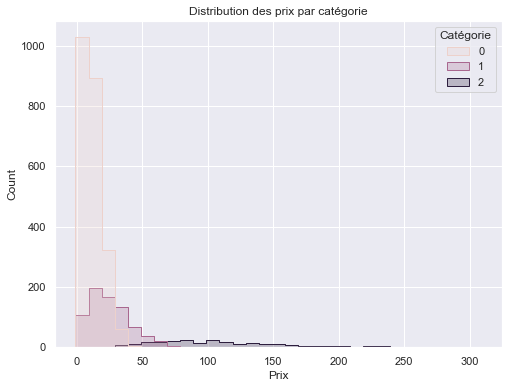

In [23]:
# Distribution des prix
# sns.distplot(data=produits, x='Prix', element='step', bins=48)
# plt.title('Distribution des prix')
# plt.show()

# Distribution des prix par catégorie
sns.histplot(data=produits, x='Prix', hue='Catégorie', element='step', binwidth=10)
plt.title('Distribution des prix par catégorie')
plt.show()

## Transactions
- Valeurs aberrantes dans *'Date'* (dates ayant 'test_' pour préfixe')
- Aucune valeur manquante
- *id_prod* et *client_id* sont des clés étrangères vers **clients** et **produits**
- dans ces variables, il y a moins de valeurs uniques que dans les tables qu'elles référencent


💡 Clé primaire : *client_id* + *Date*

🧑‍🤝‍🧑 Des clients n'ont pas passé commande, certains produits n'ont pas été vendus

In [24]:
exploration(transactions)

# --> Aucune valeur manquante
# --> Doublons dans toutes les variables : la clé primaire compte au moins 2 variables 
# --> Si id_prod et client_id sont des clés étrangères vers products et customers, ...
# --> ... il y a moins de valeurs uniques dans ces variables que dans celles des tables référencées

Info ↓ 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336890 entries, 0 to 337015
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     336890 non-null  object
 1   Date        336890 non-null  object
 2   session_id  336890 non-null  object
 3   client_id   336890 non-null  object
dtypes: object(4)
memory usage: 12.9+ MB
None 

Variable id_prod :
count     336890
unique      3266
top        1_369
freq        1081
Name: id_prod, dtype: object
0 Nan
0 zéros
3266 valeurs uniques

Variable Date :
count                              336890
unique                             336855
top       test_2021-03-01 02:30:02.237431
freq                                    2
Name: Date, dtype: object
0 Nan
0 zéros
336855 valeurs uniques

Variable session_id :
count     336890
unique    169195
top          s_0
freq          74
Name: session_id, dtype: object
0 Nan
0 zéros
169195 valeurs uniques

Variable client_id :
count 

In [25]:
# Vérification de la clé primaire sur transactions[Date, client_id]
check_pk(transactions[['client_id', 'Date']])

Clé primaire (0 duplicat)


## Jointures
- dans les variables *'client_id'* et *'id_prod'*, **transactions** contient moins de clés que les dataframes **clients** et **produits**
- jointures (**data**) ne préservant que les clés de **transactions**
- un des produits ayant fait l'objet d'une commande dans **transactions** n'apparait pas dans la table **produits**
- après jointures, des valeurs manquantes apparaissent dans *'Prix'* et *'Catégorie'* (103 NaN pour chacune des 2 variables)

In [26]:
# Fonction de comparaison de clés entre dataframes
def compare_keys(key, df1, df1_name, df2, df2_name):

    # Projection de la dataframe df1 sur la variable key
    df1_keys = pd.DataFrame(df1[key].unique())

    # Projection de la dataframe transactions sur la variable 'client_id'
    df2_keys = pd.DataFrame(df2[key].unique())

    # Longueur et valeurs uniques de df1
    print(
        'Variable \'' + key + '\' sur ' + style.bold + df1_name + style.end,
        ':', len(df1_keys), 'valeurs uniques')

    # Longueur et valeurs uniques de df2
    print(
        'Variable \'' + key + '\' sur ' + style.bold + df2_name + style.end,
        ':', len(df2_keys), 'valeurs uniques')

    # Clés dans df2 non présentes dans df1
    check_keys_1 = df1_keys.merge(
        df2_keys, 
        how='outer', 
        indicator=True).loc[lambda x : x['_merge']=='right_only']

    # Clés dans df1 non présentes dans df2
    check_keys_2 = df2_keys.merge(
        df1_keys,
        how='outer', indicator=True
    ).loc[lambda x : x['_merge']=='right_only']

    print(
        '\nClés dans ' + style.bold + 'transactions' + style.end + ' non présentes dans',
        style.bold + 'clients : ' + style.end, len(check_keys_1),
        '\nClés dans ' + style.bold + 'clients' + style.end + ' non présentes dans',
        style.bold + 'transactions : ' + style.end, len(check_keys_2))

In [27]:
# Comparaison de la clé 'client_id' entre transactions et clients
compare_keys('client_id', clients, 'clients', transactions, 'transactions')

# --> 21 clients enregistrés dans clients n'ont pas passé commande
# --> Tous les clients ayant passé commande sont référencés dans clients

Variable 'client_id' sur clients : 8623 valeurs uniques
Variable 'client_id' sur transactions : 8602 valeurs uniques

Clés dans transactions non présentes dans clients :  0 
Clés dans clients non présentes dans transactions :  21


In [28]:
# Comparaison de la clé 'id_prod' entre transactions et produits
compare_keys('id_prod', produits, 'produits', transactions, 'transactions')

# --> 22 produits de la table produits n'ont pas été achetés
# --> 1 produit dans la table transactions n'est pas référencé dans la table produits

Variable 'id_prod' sur produits : 3287 valeurs uniques
Variable 'id_prod' sur transactions : 3266 valeurs uniques

Clés dans transactions non présentes dans clients :  1 
Clés dans clients non présentes dans transactions :  22


In [29]:
# Jointure externe gauche entre transactions et clients
data = pd.merge(transactions, clients, how='left', on='client_id')

# Jointure externe gauche avec produits à droite
data = pd.merge(data, produits, how='left', on='id_prod')

data.sample(3)

,id_prod,Date,session_id,client_id,Sexe,Naissance,Âge,Prix,Catégorie
20923,0_1100,2021-05-23 13:44:31.806887,s_38452,c_6680,Homme,1979,41,3.03,0.0
82989,0_1442,2021-06-05 07:09:06.781563,s_44289,c_3725,Femme,1980,40,4.89,0.0
37292,0_1015,2021-09-22 09:42:24.362237,s_93664,c_863,Homme,1978,42,10.99,0.0


In [30]:
exploration(data)

# --> 103 valeurs manquantes apparaissent dans 'Prix' comme dans 'Catégorie'

Info ↓ 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336890 entries, 0 to 336889
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     336890 non-null  object 
 1   Date        336890 non-null  object 
 2   session_id  336890 non-null  object 
 3   client_id   336890 non-null  object 
 4   Sexe        336890 non-null  object 
 5   Naissance   336890 non-null  int64  
 6   Âge         336890 non-null  int64  
 7   Prix        336787 non-null  float64
 8   Catégorie   336787 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 25.7+ MB
None 

Variable id_prod :
count     336890
unique      3266
top        1_369
freq        1081
Name: id_prod, dtype: object
0 Nan
0 zéros
3266 valeurs uniques

Variable Date :
count                              336890
unique                             336855
top       test_2021-03-01 02:30:02.237431
freq                                    2
Name: Date, d

# Nettoyage

## Valeurs aberrantes
- *Prix* et *Date* ont chacune 74 valeurs aberrantes
- les valeurs aberrantes concernent les mêmes 74 individus-test
- suppression des lignes-test

In [31]:
# Nombre d'occurences de la valeur -1 dans 'Prix'
print(
    'La valeur -1 est présente',
    len(data[data['Prix'] == -1]),
    'fois dans la variable \'Prix\'')

# Valeurs les plus faibles de 'Prix' 
data.sort_values(by=['Prix']).head(76)

# --> Prix contient 74 valeurs aberrantes (-1)

La valeur -1 est présente 74 fois dans la variable 'Prix'


,id_prod,Date,session_id,client_id,Sexe,Naissance,Âge,Prix,Catégorie
109577,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1,Homme,2001,19,-1.00,0.0
59039,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_0,Femme,2001,19,-1.00,0.0
47169,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_1,Homme,2001,19,-1.00,0.0
129823,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0,Femme,2001,19,-1.00,0.0
151885,T_0,test_2021-03-01 02:30:02.237435,s_0,ct_1,Homme,2001,19,-1.00,0.0
...,...,...,...,...,...,...,...,...,...
88900,T_0,test_2021-03-01 02:30:02.237415,s_0,ct_0,Femme,2001,19,-1.00,0.0
317233,T_0,test_2021-03-01 02:30:02.237448,s_0,ct_0,Femme,2001,19,-1.00,0.0
137476,T_0,test_2021-03-01 02:30:02.237432,s_0,ct_0,Femme,2001,19,-1.00,0.0
57641,0_528,2021-06-24 18:55:00.312636,s_53240,c_5636,Femme,1989,31,0.62,0.0


In [32]:
# Nombre d'occurences du préfixe test_ dans 'Date'
print(
    data['Date'].str.contains('test_').value_counts().tolist()[1],
    'dates ont \'test_\' pour préfixe')

# Dernières valeurs de 'Date'
data.sort_values(by=['Date']).tail(76)

# --> Les 74 dernières valeurs de 'Date' ont pour préfixe 'test_'

74 dates ont 'test_' pour préfixe


,id_prod,Date,session_id,client_id,Sexe,Naissance,Âge,Prix,Catégorie
301419,0_1403,2022-02-28 23:59:02.381670,s_172423,c_1460,Homme,1989,31,15.99,0.0
79882,0_1775,2022-02-28 23:59:58.040472,s_172423,c_1460,Homme,1989,31,6.99,0.0
22347,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_1,Homme,2001,19,-1.00,0.0
133414,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_0,Femme,2001,19,-1.00,0.0
57752,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_1,Homme,2001,19,-1.00,0.0
...,...,...,...,...,...,...,...,...,...
26814,T_0,test_2021-03-01 02:30:02.237447,s_0,ct_1,Homme,2001,19,-1.00,0.0
317233,T_0,test_2021-03-01 02:30:02.237448,s_0,ct_0,Femme,2001,19,-1.00,0.0
203184,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_0,Femme,2001,19,-1.00,0.0
245271,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1,Homme,2001,19,-1.00,0.0


In [33]:
# Lignes communes au préfixe test_ et à la valeur -1
subset_test = data[(data['Prix'] == -1) & (data['Date'].str.contains('test_'))]
subset_test

# --> La combinaison des 2 valeurs aberrantes renvoie aux 74 mêmes lignes

,id_prod,Date,session_id,client_id,Sexe,Naissance,Âge,Prix,Catégorie
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1,Homme,2001,19,-1.0,0.0
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1,Homme,2001,19,-1.0,0.0
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1,Homme,2001,19,-1.0,0.0
5955,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0,Femme,2001,19,-1.0,0.0
7283,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1,Homme,2001,19,-1.0,0.0
...,...,...,...,...,...,...,...,...,...
264229,T_0,test_2021-03-01 02:30:02.237416,s_0,ct_1,Homme,2001,19,-1.0,0.0
288815,T_0,test_2021-03-01 02:30:02.237415,s_0,ct_1,Homme,2001,19,-1.0,0.0
293003,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_0,Femme,2001,19,-1.0,0.0
298292,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1,Homme,2001,19,-1.0,0.0


In [34]:
# Nombre de lignes dans data avant drop
len_data_before = len(data)

# Suppression des lignes-test
data.drop(subset_test.index, inplace=True)

# Nombre de lignes dans data après nettoyage
print(len_data_before - len(data), 'lignes supprimées')

# Réinitialisation des index de data
data.reset_index(inplace=True)

74 lignes supprimées


## Valeurs manquantes

### Identification
- *Catégorie* et *Prix* ont chacune 103 valeurs manquantes
- toutes correspondent aux 103 individus du produit 0_2245
- le produit ne réprésente que 0.03% du dataset : on pourrait le mettre de côté sans fausser les analyses
- autant d'hommes que de femmes ont acheté le produit
- l'année de naissance des acheteurs se contentre autour de 1980

💡 La moitié des acheteurs du produit sont nés entre 1973 et 1984

In [35]:
# Vérification des NaN dans une variable
# et des valeurs correspondantes d'une seconde variable
def verif_nan(variable, variable_check):
  # Lignes ayant une valeur nulle dans
  null = data[data[variable].isnull()]
  print(
    len(null), 'lignes n\'ont pas de valeur dans \'' + variable + '\' :',
    'toutes ont', null[variable_check].unique(), 'pour ' + variable_check)

verif_nan('Catégorie', 'id_prod')
verif_nan('Prix', 'id_prod')

# --> 'Catégorie' et 'Prix' ont le même nombre de NaN
# --> Tous les individus avec NaN ont 0_2245 pour valeur d'id_prod

103 lignes n'ont pas de valeur dans 'Catégorie' : toutes ont ['0_2245'] pour id_prod
103 lignes n'ont pas de valeur dans 'Prix' : toutes ont ['0_2245'] pour id_prod


In [36]:
subset_2245 = data[data['id_prod']=='0_2245']
subset_2245

# --> 103 individus pour le produit 0_2245
# --> Le produit 0_2245 est responsable de tous les NaN

,index,id_prod,Date,session_id,client_id,Sexe,Naissance,Âge,Prix,Catégorie
6231,6235,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533,Homme,1972,48,NaN,NaN
10797,10802,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954,Homme,1973,47,NaN,NaN
14045,14051,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120,Femme,1975,45,NaN,NaN
17480,17486,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964,Femme,1982,38,NaN,NaN
21071,21078,0_2245,2021-03-01 00:09:29.301897,s_3,c_580,Homme,1988,32,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
322523,322597,0_2245,2021-04-06 19:59:19.462288,s_16936,c_4167,Femme,1979,41,NaN,NaN
329226,329300,0_2245,2021-03-30 23:29:02.347672,s_13738,c_7790,Femme,1983,37,NaN,NaN
330297,330371,0_2245,2021-12-03 14:14:40.444177,s_128815,c_6189,Femme,1984,36,NaN,NaN
335331,335405,0_2245,2021-04-27 18:58:47.703374,s_26624,c_1595,Femme,1973,47,NaN,NaN


In [37]:
# Proportion de l'échantillon par rapport au dataset
print(
    'Le sous-échantillon représente',
    round((len(subset_2245) / len(data) * 100), 2),
    '% du dataset')

# --> Supprimer les valeurs plutôt que les remplacer n'impacterait pas l'analyse

Le sous-échantillon représente 0.03 % du dataset


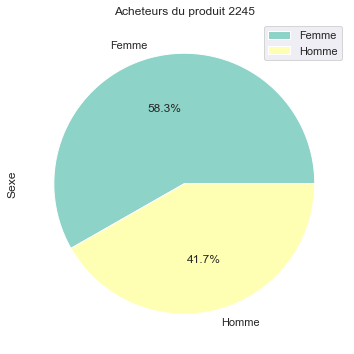

In [38]:
# Proportion des modalités de 'Sexe' dans le sous-échantillon
subset_2245['Sexe'].value_counts(normalize=True).plot(
    kind='pie',
    legend=True,
    autopct='%1.1f%%'
)
plt.title('Acheteurs du produit 2245')
plt.show()

# --> Presque autant de femmes que d'hommes 
# --> La variable 'Sexe' ne définit pas les acheteurs du produits 0_2245 

Indicateurs de position : 
Mode(s) : [1978] (fréquence : 8.7 %) 
Moyenne : 1977.3 
Médiane : 1979.0 
1er quartile : 1973.0 
3ème quartile : 1984.0 
Indicateurs de dispersion : 
Minimum : 1933 
Maximum : 2002 
Étendue : 69 
Variance : 137.4 
Écart-type :  11.7 
Coeff. de variation : 0.0 
Skewness : -1.5 ( distribution étalée à gauche ) 
Kurtosis : 3.5 ( distribution moins aplatie que la normale gaussienne )


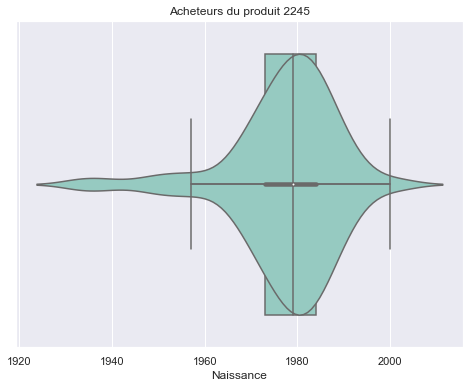

In [39]:
# Indicateurs de la variable 'Naissance' sur le sous-échantillon
indicateurs(subset_2245, 'Naissance')

# Distribution des années de naissance du sous-échantillon
sns.violinplot(data=subset_2245, x='Naissance', showfliers=False)
sns.boxplot(data=subset_2245, x='Naissance', showfliers=False)
plt.title('Acheteurs du produit 2245')
plt.show()

# --> # --> La moitié des individus sont nés entre 1973 et 1984
# --> 8% des acheteurs des individus sont nés en 1978
# --> Vu la petit taille de l'échantillon, l'indicateur est significatif

### Valeurs de remplacement
- recherche des valeurs de remplacement pour *Catégorie* et *Prix*, à partir des variables disponibles pour le sous-échantillon produit (*Date*, *Sexe* et *Naissance*)
- à partir d'un échantillon des clients nés entre 1973 et 1984
- les clients du sous-échantillon achètent en majorité des produits de la catégorie 0
- les préfixes des valeurs d'*id_prod* correspondent systématiquement à la catégorie
- remplacement des valeurs manquantes par la catégorie 0 et son mode dans le sous-échantillon : 4.99

💡 *Prix* et *Catégorie* apparaissent corrélés (les catégories sont 3 classes de prix ordonnées)

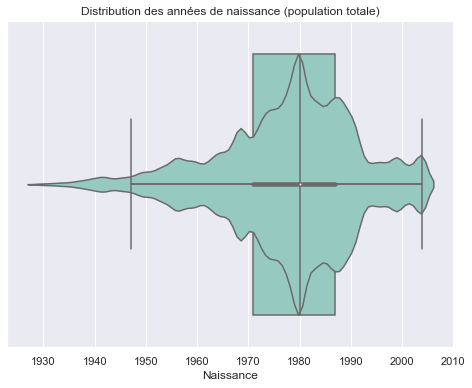

1er quatile : 1971.0 
3ème quartile : 1987.0


In [40]:
# Quartiles d'âges de la population totale
sns.violinplot(data=data, x='Naissance', showfliers=False)
sns.boxplot(data=data, x='Naissance', showfliers=False)
plt.title('Distribution des années de naissance (population totale)')
plt.show()

# Affichage des quartiles
print(
    '1er quatile :', data['Naissance'].quantile(.25),
    '\n3ème quartile :', data['Naissance'].quantile(.75))

# --> La moitié des individus du dataset sont nés entre 1971 et 1987
# --> C'est presque le même espace interquartile que le sous-échantillon produit

In [41]:
# Individus de data compris dans l'intervalle interquartile du sous-échantillon
subset_naissances = data[
    (data['Naissance']>=1973) & (data['Naissance']<=1984)
]

subset_naissances.sample(3)

,index,id_prod,Date,session_id,client_id,Sexe,Naissance,Âge,Prix,Catégorie
279117,279187,0_1228,2021-04-22 10:14:20.975681,s_24098,c_7316,Femme,1984,36,3.55,0.0
256411,256478,0_1557,2022-02-09 05:21:00.828647,s_162289,c_1609,Homme,1980,40,6.99,0.0
141967,142022,0_1378,2021-03-10 03:36:06.658496,s_4214,c_8287,Homme,1984,36,13.96,0.0


Indicateurs de position : 
Mode(s) : [0.0] (fréquence : 77.0 %) 
Moyenne : 0.2 
Médiane : 0.0 
1er quartile : 0.0 
3ème quartile : 0.0 
Indicateurs de dispersion : 
Minimum : 0.0 
Maximum : 2.0 
Étendue : 2.0 
Variance : 0.2 
Écart-type :  0.4 
Coeff. de variation : 1.8 
Skewness : 1.4 ( distribution étalée à droite ) 
Kurtosis : 0.2 ( distribution moins aplatie que la normale gaussienne )


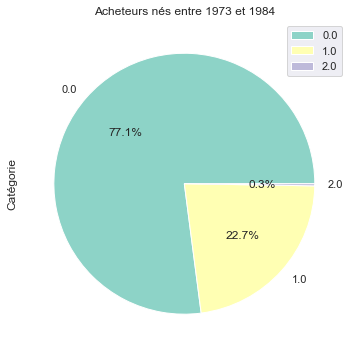

In [42]:
# Indicateurs de la variable 'Catégorie' du sous-échantillon 
indicateurs(subset_naissances, 'Catégorie')

# Proportion des modalités de 'Catégorie' dans le sous-échantillon
subset_naissances['Catégorie'].value_counts(normalize=True).plot(
    kind='pie',
    legend=True,
    autopct='%1.1f%%'
)
plt.title('Acheteurs nés entre 1973 et 1984')
plt.show()

# --> Les acheteurs semblables à ceux du produit 2245 consomment surtout la catégorie 0

In [43]:
# Dataframe-test, sans NaN
data_test = data.dropna()

# Réduction de la variable 'id_prod' à 2 caractères
data_test['id_prod'] = data_test['id_prod'].str[:2]

# Préfixes uniques dans 'id_prod' pour chaque catégorie 
for i in data_test['Catégorie'].unique():
    print(
        'Préfique unique pour la catégorie', i, ':',
        data_test[data_test['Catégorie']==i]['id_prod'].unique())

# Les préfixes des identifiants produits correspondent à leur catégorie
# 0_2245 appartient à la catégorie 0

Préfique unique pour la catégorie 0.0 : ['0_']
Préfique unique pour la catégorie 2.0 : ['2_']
Préfique unique pour la catégorie 1.0 : ['1_']


<ipython-input-43-e3833bb00069>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['id_prod'] = data_test['id_prod'].str[:2]


Indicateurs de position : 
Mode(s) : [4.99] (fréquence : 3.4 %) 
Moyenne : 13.0 
Médiane : 11.99 
1er quartile : 7.4 
3ème quartile : 17.0 
Indicateurs de dispersion : 
Minimum : 0.62 
Maximum : 300.0 
Étendue : 299.4 
Variance : 64.1 
Écart-type :  8.0 
Coeff. de variation : 0.6 
Skewness : 4.8 ( distribution étalée à droite ) 
Kurtosis : 85.5 ( distribution moins aplatie que la normale gaussienne )


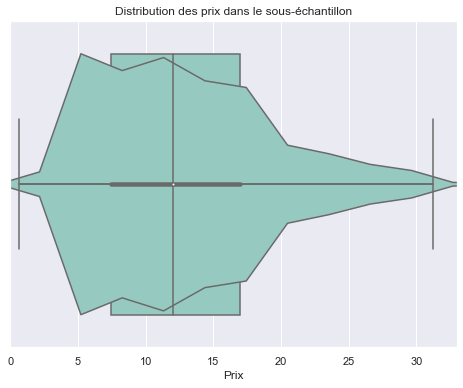

In [44]:
# Indicateurs de la variable 'Prix' du sous-échantillon 
indicateurs(subset_naissances, 'Prix')

sns.violinplot(data=subset_naissances, x='Prix', showfliers=False)
sns.boxplot(data=subset_naissances, x='Prix', showfliers=False)
plt.xlim([0,subset_naissances['Prix'].quantile(.99)])
plt.title('Distribution des prix dans le sous-échantillon')
plt.show()

# --> Fortes concentrations des prix entre 4.99 et 11.99 

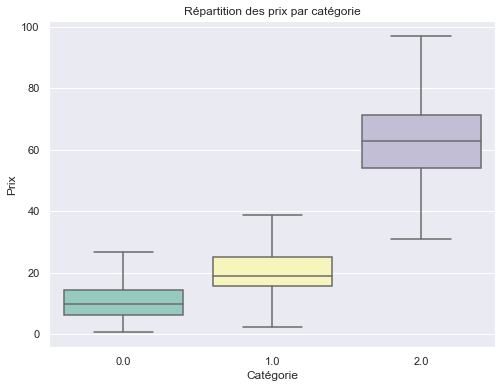

In [45]:
# Distribution des prix par catégorie
sns.boxplot(data=data, x='Catégorie', y='Prix', showfliers=False)
plt.title('Répartition des prix par catégorie')
plt.show()

# --> Les catégories sont corrélées au prix
# --> Les catégories sont des classes de prix ordonnées

Indicateurs de position : 
Mode(s) : [4.99] (fréquence : 4.4 %) 
Moyenne : 10.6 
Médiane : 9.99 
1er quartile : 6.3 
3ème quartile : 14.4 
Indicateurs de dispersion : 
Minimum : 0.62 
Maximum : 40.99 
Étendue : 40.4 
Variance : 24.2 
Écart-type :  4.9 
Coeff. de variation : 0.5 
Skewness : 0.4 ( distribution étalée à droite ) 
Kurtosis : -0.4 ( distribution plus aplatie que la normale gaussienne )


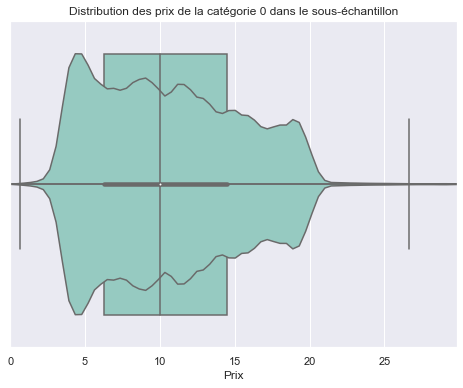

In [46]:
# Indicateurs de la variable 'Prix' pour la catégorie 0 du sous-échantillon 
masque_cat_0 = subset_naissances[subset_naissances['Catégorie']==0]
indicateurs(masque_cat_0, 'Prix')

sns.violinplot(data=masque_cat_0, x='Prix', showfliers=False)
sns.boxplot(data=masque_cat_0, x='Prix', showfliers=False)
plt.xlim([0,masque_cat_0['Prix'].quantile(.999)])
plt.title('Distribution des prix de la catégorie 0 dans le sous-échantillon')
plt.show()

# --> La médiane est plus basse qu'avec les autres catégories
# --> La fréquence du mode (4%) est insuffisante : on retient la médiane (9.99)

In [47]:
# Remplacement des valeurs manquantes du produit 0_2245
data['Catégorie'].replace(np.nan, 0, inplace=True)
data['Prix'].replace(np.nan, 9.99, inplace=True)

# Affichage du produit 0_2245
data[data['id_prod']=='0_2245'].sample(3)

,index,id_prod,Date,session_id,client_id,Sexe,Naissance,Âge,Prix,Catégorie
30874,30886,0_2245,2021-08-22 08:51:27.564509,s_79102,c_6752,Homme,1987,33,9.99,0.0
251130,251196,0_2245,2022-01-15 06:19:44.035000,s_150064,c_4765,Homme,1982,38,9.99,0.0
184856,184915,0_2245,2021-12-14 22:34:54.589921,s_134446,c_4854,Homme,1968,52,9.99,0.0


## Dates manquantes
- les données du 2 au 27 octobre sont manquantes pour la catégorie 1
- suppression des données du mois d'octobre pour les autres catégories
- 5% du dataset est écarté

💡 L'histogramme des dates montre des distributions différentes pour chaque catégorie : possible corrélation entre les dates et la catégorie

In [48]:
# Type des valeurs de 'Date' avant conversion 
print(
    style.bold + 'Type de la variable date :\n' + style.end +
    'Avant conversion :', type(data['Date'].loc[0]))

# Conversion de la variable 'Date' en datetime
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Type des valeurs après conversion
print('Après conversion :', type(data['Date'].loc[0]))

Type de la variable date :
Avant conversion : <class 'str'>
Après conversion : <class 'pandas._libs.tslibs.timestamps.Timestamp'>


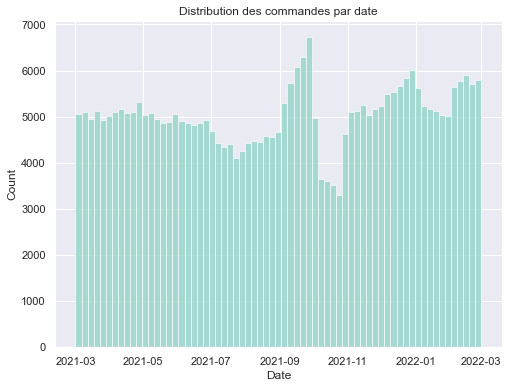

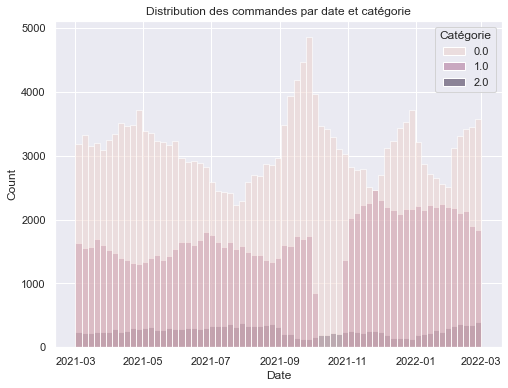

In [49]:
sns.histplot(data=data, x='Date')
plt.title('Distribution des commandes par date')
plt.show()

sns.histplot(data=data, x='Date', hue='Catégorie')
plt.title('Distribution des commandes par date et catégorie')
plt.show()

# --> Creux anormal dans les commandes du mois d'octobre
# --> Les données d'octobre sont manquantes pour la catégorie 1
# --> Les distributions sont différentes pour chaque catégorie

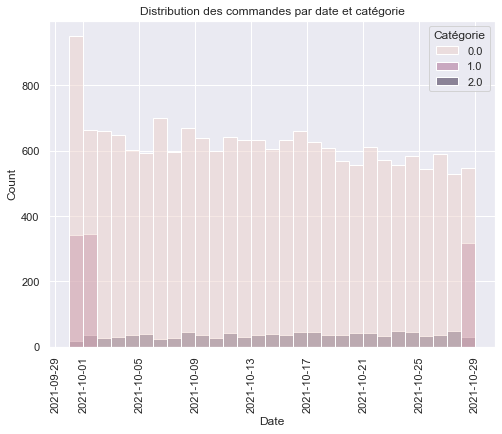

,index,id_prod,Date,session_id,client_id,Sexe,Naissance,Âge,Prix,Catégorie
52574,52593,1_451,2021-10-30 07:16:53.406625,s_112168,c_7219,Femme,1966,54,20.99,1.0
335100,335174,1_283,2021-10-31 10:45:28.565949,s_112695,c_7588,Femme,2004,16,14.99,1.0
289996,290067,1_417,2021-10-30 23:38:41.705027,s_112462,c_6714,Femme,1968,52,20.99,1.0
223980,224042,1_417,2021-10-28 15:44:30.897681,s_111382,c_8541,Homme,1971,49,20.99,1.0
297366,297438,1_475,2021-10-31 11:44:19.185310,s_112711,c_3454,Homme,1969,51,20.99,1.0


In [50]:
# --> Distribution des commandes du mois d'octobre
sns.histplot(
    data=data[(data['Date']>'2021-09-30') & (data['Date']<'2021-10-29')], 
    x='Date', 
    hue='Catégorie',
    binwidth=1)
plt.title('Distribution des commandes par date et catégorie')
plt.xticks(rotation=90)
plt.show()

data[
    (data['Date']>'2021-09-30') & 
    (data['Date']<'2021-11-01') & 
    (data['Catégorie']==1)].sample(5)

# --> Les valeurs de la catégorie 1 sont manquantes du 2 au 27 octobre

Nombre de lignes avant suppression : 336816
Nombre de lignes après suppression : 318955 ( 5.3 % du dataset écarté )


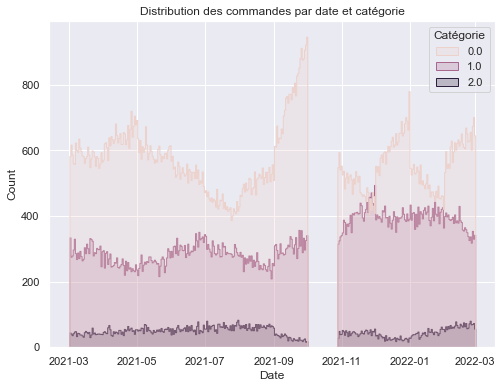

In [51]:
# Nombre de lignes avant drop
len_data_before = len(data)
print('Nombre de lignes avant suppression :', len_data_before)

# Suppression des données 2 au 27 octobre (toutes catégories)
data.drop(data[
    (data['Date']>'2021-10-01') & 
    (data['Date']<'2021-10-28')].index, inplace=True)

# Nombre de lignes dans data après nettoyage
print(
    'Nombre de lignes après suppression :', len(data), '(',
    round(((len_data_before - len(data)) / len_data_before * 100), 1),
    '% du dataset écarté )')

# Visualisation
sns.histplot(data=data, x='Date', hue='Catégorie', element='step', binwidth=1)
plt.title('Distribution des commandes par date et catégorie')
plt.show()

# Analyse : clients

## Typologie
- 4 des 8600 clients agrègent à eux seuls 7% du chiffre d'affaires
- distinction des clients en 2 échantillons : B2B pour les 4 plus gros clients, B2C pour les autres (paniers annuels inférieurs à 2500)

In [52]:
# Panier annuel des clients
panier_annuel = data.pivot_table(
    index='client_id', 
    values='Prix', 
    aggfunc='sum'
    ).sort_values(by='Prix', ascending=False).reset_index()

panier_annuel.rename(columns={'Prix': 'CA annuel'}, inplace=True)

# Création d'une variable 'Type' (valeurs : B2B ou B2C)
panier_annuel['Type'] = 'B2C'
panier_annuel.loc[:3]['Type'] = 'B2B'

panier_annuel

# --> Les paniers des 4 premiers clients est nettement supérieur aux 8000 autres

<ipython-input-52-d8182927c75e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panier_annuel.loc[:3]['Type'] = 'B2B'


,client_id,CA annuel,Type
0,c_1609,152347.32,B2B
1,c_4958,138466.78,B2B
2,c_6714,70138.29,B2B
3,c_3454,53271.88,B2B
4,c_8026,2434.49,B2C
...,...,...,...
8594,c_8032,8.82,B2C
8595,c_890,6.08,B2C
8596,c_1675,5.57,B2C
8597,c_8114,4.99,B2C


In [53]:
# Jointure des paniers annuels sur data
data = data.merge(panier_annuel, how='left', on='client_id')
data.sample(3)

,index,id_prod,Date,session_id,client_id,Sexe,Naissance,Âge,Prix,Catégorie,CA annuel,Type
243060,256726,0_1044,2021-05-28 19:06:30.349625,s_40852,c_580,Homme,1988,32,6.59,0.0,1887.25,B2C
181858,192175,1_279,2021-08-11 19:12:43.650419,s_74424,c_4237,Homme,1978,42,27.99,1.0,858.61,B2C
92919,98251,1_367,2022-02-20 00:18:55.544744,s_167831,c_4864,Femme,1983,37,13.99,1.0,635.34,B2C


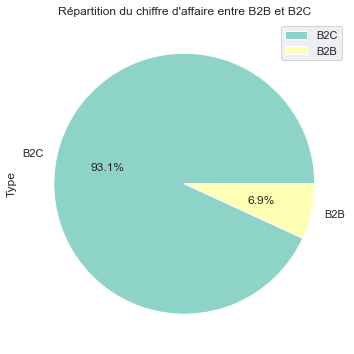

In [54]:
data['Type'].value_counts(normalize=True).plot(
    kind='pie',
    legend=True,
    autopct='%1.1f%%'
)
plt.title('Répartition du chiffre d\'affaire entre B2B et B2C')
plt.show()

# --> Le B2B représente 7% du chiffre d'affaire

In [55]:
b2b = data[data['Type'] == 'B2B']
b2b.sample()

,index,id_prod,Date,session_id,client_id,Sexe,Naissance,Âge,Prix,Catégorie,CA annuel,Type
169138,178762,1_558,2022-02-07 22:35:49.542556,s_161619,c_1609,Homme,1980,40,24.51,1.0,152347.32,B2B


In [56]:
b2c = data[data['Type'] == 'B2C']
b2c.sample()

,index,id_prod,Date,session_id,client_id,Sexe,Naissance,Âge,Prix,Catégorie,CA annuel,Type
83397,88220,1_445,2021-09-09 09:43:59.620287,s_87231,c_5098,Homme,1965,55,23.99,1.0,606.24,B2C


## B2B
- l'âge et le sexe des 4 clients n'ont pas à être analysés

In [57]:
# Attributs des 4 clients
b2b.pivot_table(index='client_id')[['Naissance', 'Âge', 'CA annuel', 'Catégorie']]

,Naissance,Âge,CA annuel,Catégorie
client_id,,,,
c_1609,1980,40,152347.32,0.214137
c_3454,1969,51,53271.88,0.613808
c_4958,1999,21,138466.78,1.635081
c_6714,1968,52,70138.29,0.457823


### Par date

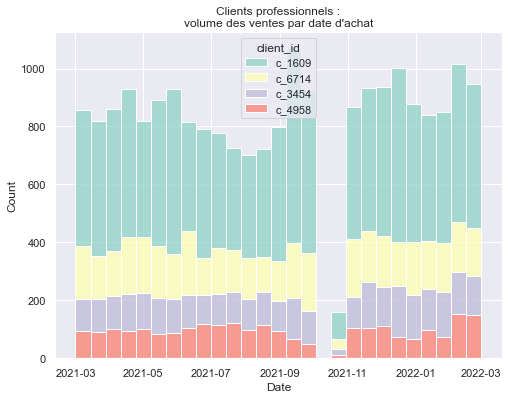

Client c_1609


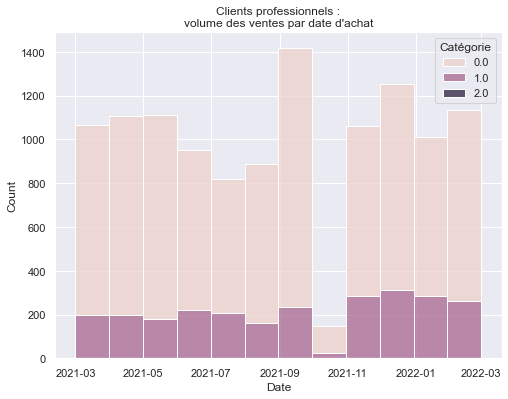

Client c_6714


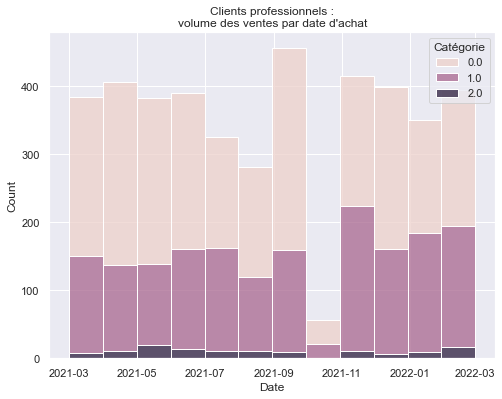

Client c_3454


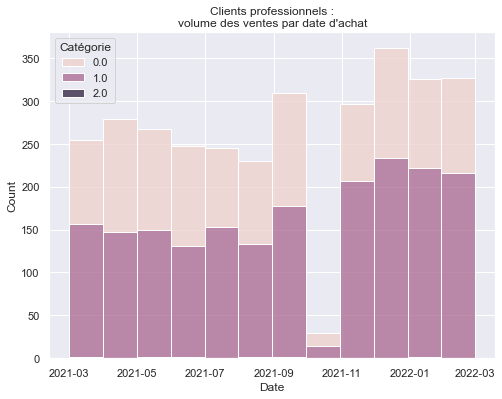

Client c_4958


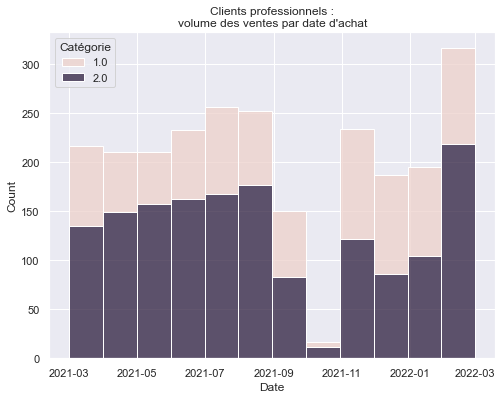

In [58]:
sns.histplot(data=b2b, x='Date', hue='client_id', multiple='stack', bins=27)
plt.title('Clients professionnels :\nvolume des ventes par date d\'achat')
plt.show()

for i in b2b['client_id'].unique():
    print('Client', i)
    sns.histplot(data=b2b[b2b['client_id']==i], x='Date', hue='Catégorie', multiple='stack', bins=12)
    plt.title('Clients professionnels :\nvolume des ventes par date d\'achat')
    plt.show()
    
# --> Le plus gros client (c_1609) a des pics d'achat au mois de septembre et décembre
# --> Le client c_4958 a un fort pic au mois de février

Client c_1609


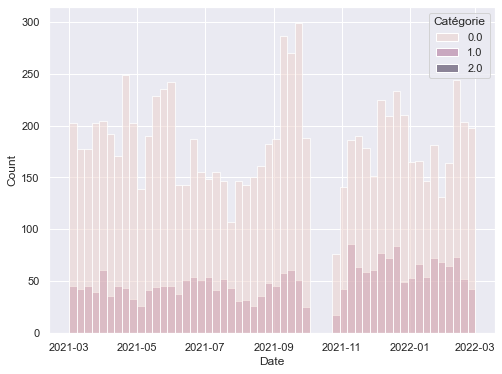

Client c_6714


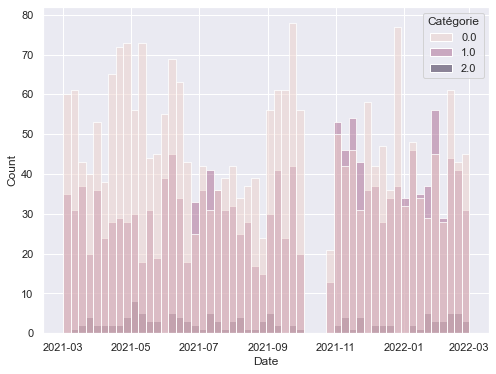

Client c_3454


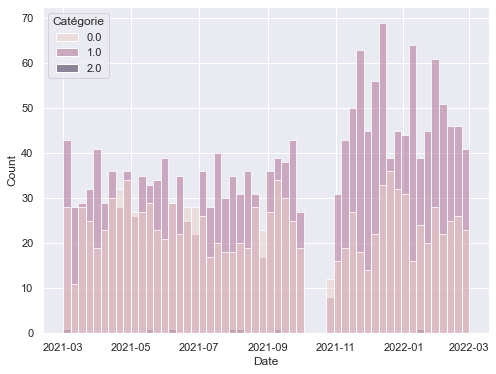

Client c_4958


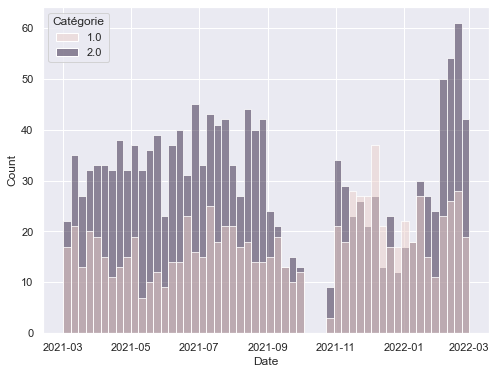

In [59]:


for i in b2b['client_id'].unique():
    print('Client', i)
    sns.histplot(
        data=b2b[b2b['client_id'] == i], 
        x='Date', 
        hue='Catégorie', 
        bins=54)
    plt.show()

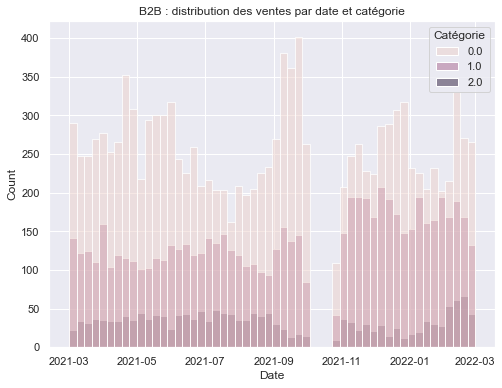

In [60]:
sns.histplot(
    data=b2b, 
    x='Date', 
    hue='Catégorie', 
    bins=54)
plt.title('B2B : distribution des ventes par date et catégorie')
plt.show()

# --> Catégorie 0 : surtout achetée en septembre
# --> Catégorie 0 : 2 autres pics aux mois de mai et décembre
# --> Catégorie 1 : pic au mois de décembre

### Par prix

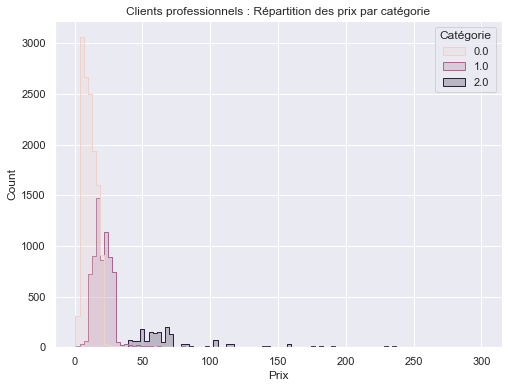

In [61]:
sns.histplot(data=b2b, x='Prix', hue='Catégorie', element='step', bins=100)
plt.title('Clients professionnels : Répartition des prix par catégorie')
plt.show()

# --> Les professionnels achètent principalement la catégorie 0

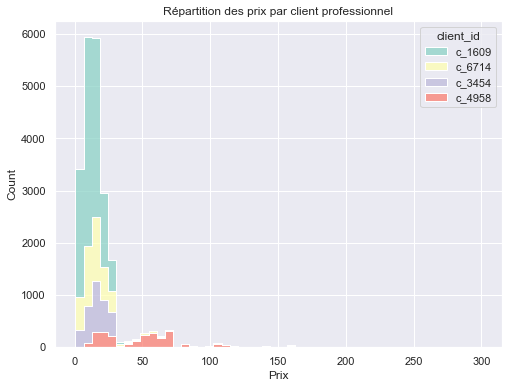

In [62]:
sns.histplot(data=b2b, x='Prix', hue='client_id', element='step', multiple='stack', bins=50)
plt.title('Répartition des prix par client professionnel')
plt.show()

# --> Le client c_1609 agrège la majorité des commandes

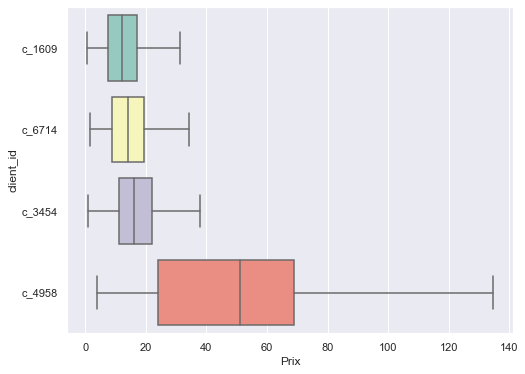

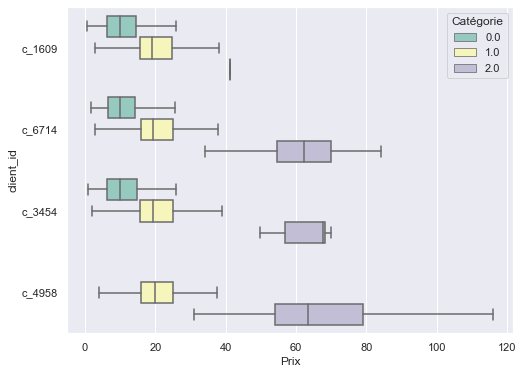

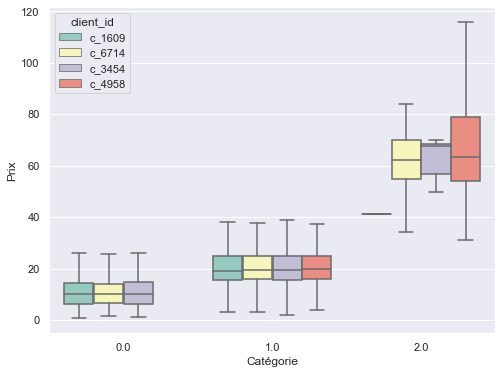

In [63]:
sns.boxplot(data=b2b, x='Prix', y='client_id', showfliers=False)
plt.show()

sns.boxplot(data=b2b, x='Prix', y='client_id', hue='Catégorie', showfliers=False)
plt.show()

sns.boxplot(data=b2b, x='Catégorie', y='Prix', hue='client_id', showfliers=False)
plt.show()

# --> Le client c_1609 achète principalement la catégorie 0, pratiquement pas la catégorie 2
# --> Le client c_4558 achète principalement la catégorie 2, pratiquement pas la catégorie 2

## B2C

### Par sexe
- les femmes achètent autant que les hommes, à la même fréquence
- les 2 sexes ont les mêmes distributions d'âge et d'achats dans chaque catégorie
- le sexe n'est corrélé à aucune variable

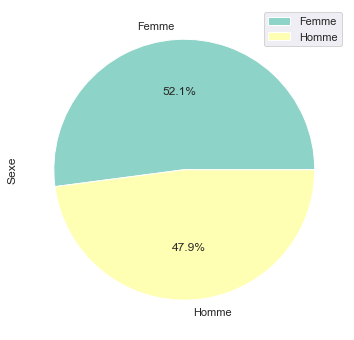

In [64]:
b2c['Sexe'].value_counts(normalize=True).plot(
    kind='pie',
    legend=True,
    autopct='%1.1f%%'
)
plt.show()

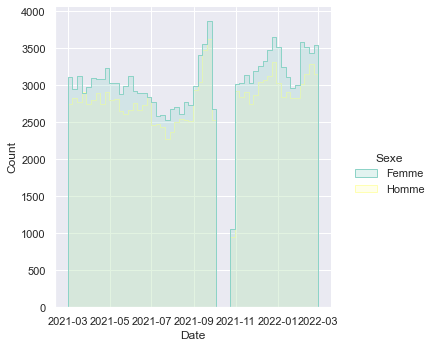

In [65]:
sns.displot(data=b2c, x='Date', hue='Sexe', element='step', bins=54)
plt.show()

# Les distributions des 2 sexes ont les mêmes formes
# Les 2 groupes achètent autant aux mêmes périodes de l'année

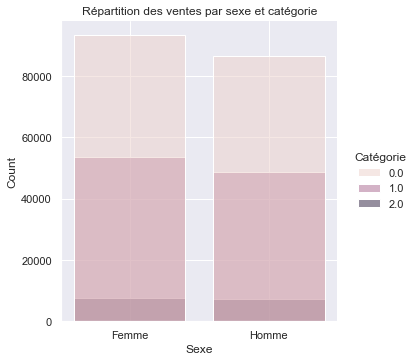

In [66]:
sns.displot(b2c, x="Sexe", hue='Catégorie', shrink=.8)
plt.title('Répartition des ventes par sexe et catégorie')
plt.show()

# --> Les 2 sexes ont le même volume d'achats
# --> Les 2 sexes achètent autant dans chaque catégorie

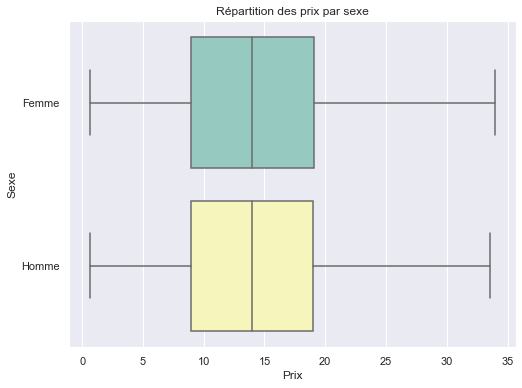

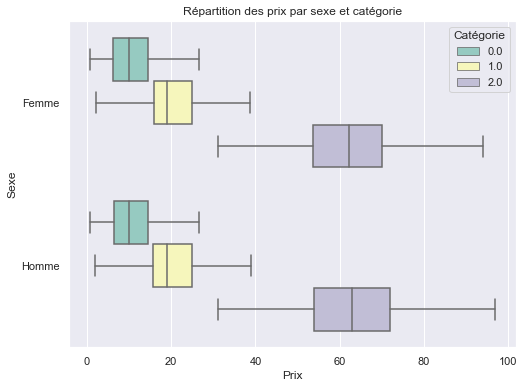

In [67]:
sns.boxplot(data=b2c, x='Prix', y='Sexe', showfliers=False)
plt.title('Répartition des prix par sexe')
plt.show()

sns.boxplot(data=b2c, x='Prix', y='Sexe', hue='Catégorie', showfliers=False)
plt.title('Répartition des prix par sexe et catégorie')
plt.show()

# --> La catégorie semble corrélée au prix

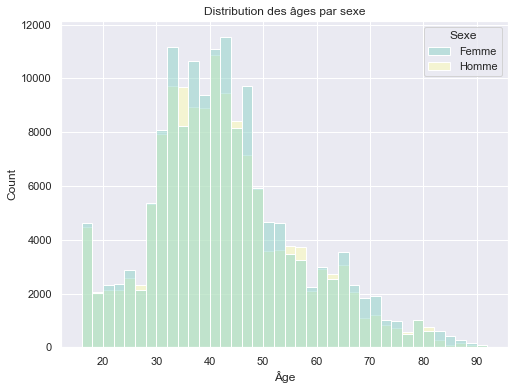

In [68]:
# Distribution des âges par sexe
sns.histplot(data=b2c, x='Âge', hue='Sexe', binwidth=2)
plt.title('Distribution des âges par sexe')
plt.show()

# --> Les distributions ont les mêmes formes

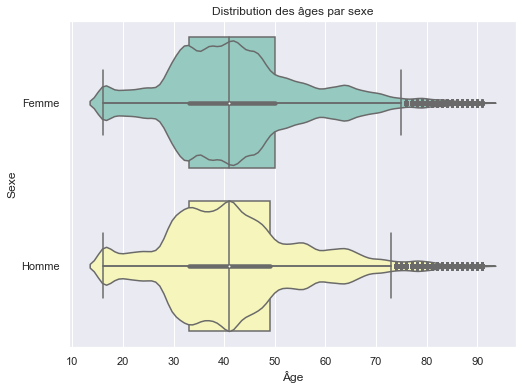

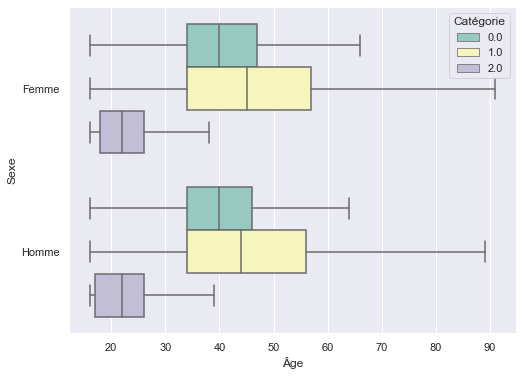

In [69]:
sns.boxplot(data=b2c, x='Âge', y='Sexe')
sns.violinplot(data=b2c, x='Âge', y='Sexe')
plt.title('Distribution des âges par sexe')
plt.show()

# Affichage de 'Catégorie' (2 catégorielles avec 'Sexe')
sns.boxplot(data=b2c, x='Âge', y='Sexe', hue='Catégorie', showfliers=False)
plt.show()

# --> La catégorie semble corrélée à l'âge
# --> Les mêmes distribution d'âge chez les femmes et les hommes
# --> Excepté un pic anormal vers 40 ans chez les hommes

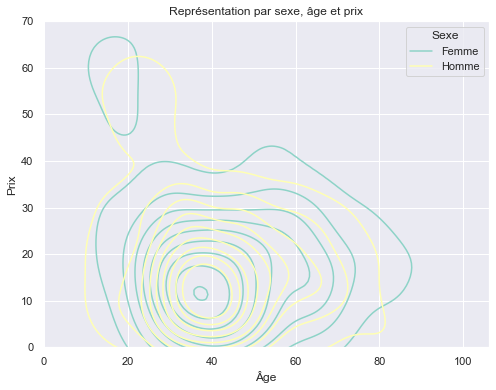

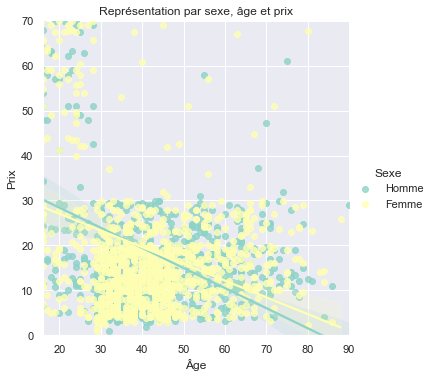

In [70]:
sns.kdeplot(
    data=b2c.sample(500), 
    y='Prix', 
    x='Âge', 
    hue='Sexe'
)
plt.title('Représentation par sexe, âge et prix')
plt.ylim(0, 70)
plt.show()

sns.lmplot(
    data=b2c.sample(2000), 
    y='Prix', 
    x='Âge', 
    hue='Sexe'
)
plt.title('Représentation par sexe, âge et prix')
plt.ylim(0, 70)
plt.show()

### Par âge

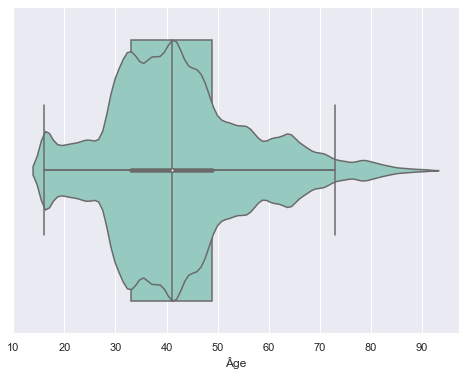

In [71]:
sns.boxplot(data=b2c, x='Âge', showfliers=False)
sns.violinplot(data=b2c, x='Âge', showfliers=False, orient='h')
plt.show()

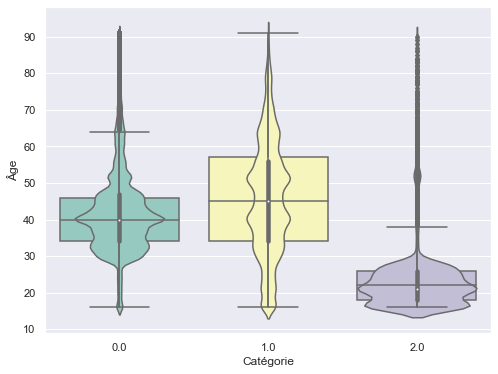

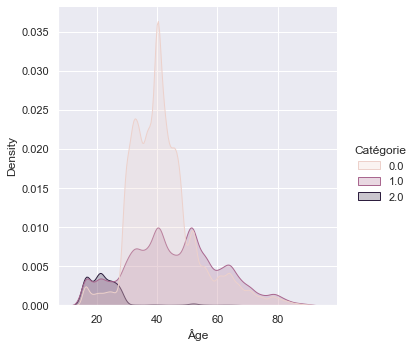

In [72]:
sns.boxplot(data=b2c, y='Âge', x='Catégorie')
sns.violinplot(data=data, y='Âge', x='Catégorie', showfliers=False, orient='v')
plt.show()

sns.displot(data=data, x='Âge', hue='Catégorie', kind='kde', fill=True)
plt.show()

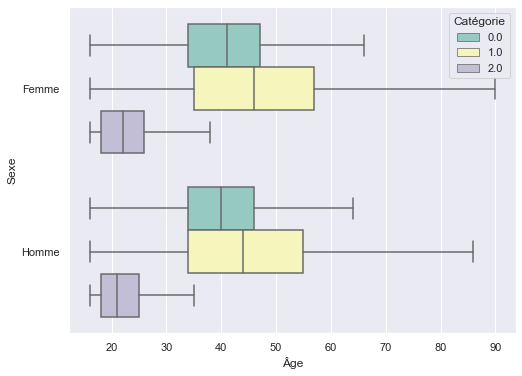

In [73]:
sns.boxplot(data=data, x='Âge', y='Sexe', hue='Catégorie', showfliers=False)
plt.show()

# La catégorie semble corrélée à l'âge

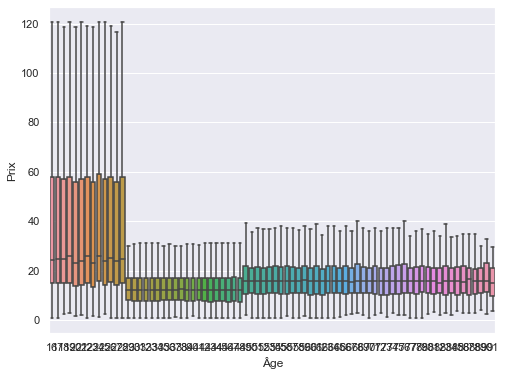

In [74]:
sns.boxplot(data=b2c, x='Âge', y='Prix', showfliers=False)
sns.set(rc={'figure.figsize':(18,6)})
plt.show()

# --> En-dessous de 28 ans, les clients achètent des livres beaucoup plus chers 

Sample 1 :


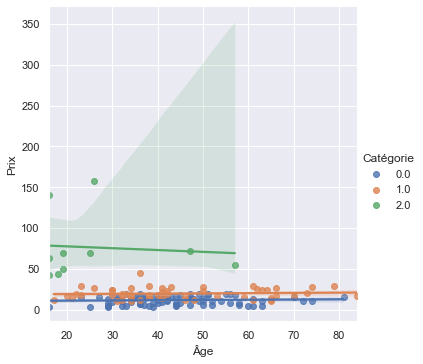

Sample 2 :


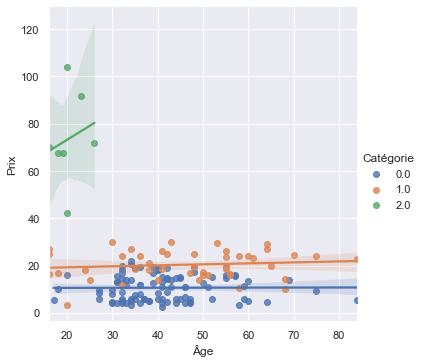

In [75]:
for i in range(0,2):
    sample = b2c.sample(150)
    print('Sample', i+1, ':')
    sns.lmplot(data=sample, x='Âge', y='Prix', hue='Catégorie')
    plt.show()
    # sns.relplot(
    #    data=sample, x='Âge', y='Prix', hue='Catégorie', style='Catégorie', 
    #    kind='line', markers=True, dashes=False
    #)
    # plt.show()

### Par date

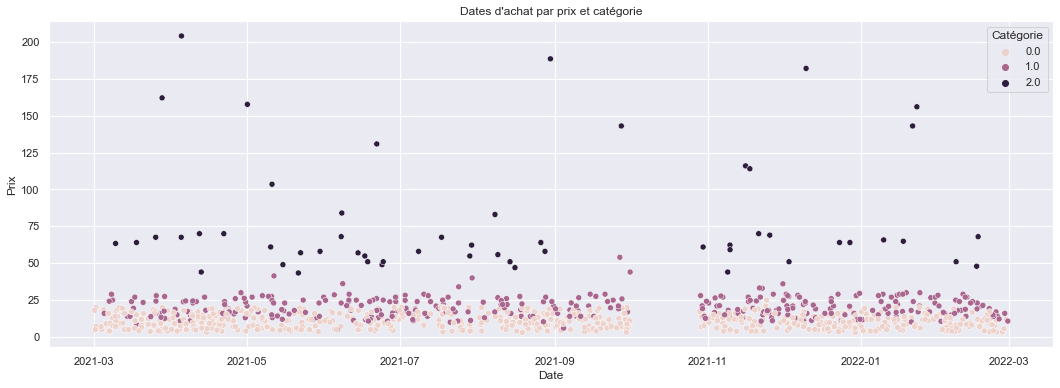

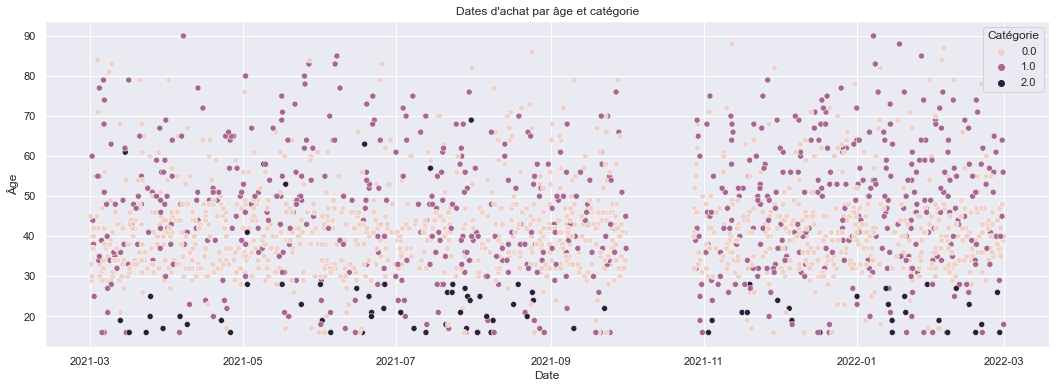

In [76]:
sns.scatterplot(
    data=b2c.sample(1000), 
    y="Prix",
    x='Date', 
    hue='Catégorie'
    )
plt.title('Dates d\'achat par prix et catégorie')
plt.show()

sns.scatterplot(
    data=b2c.sample(2000), 
    y="Âge",
    x='Date', 
    hue='Catégorie'
    )
plt.title('Dates d\'achat par âge et catégorie')
plt.show()

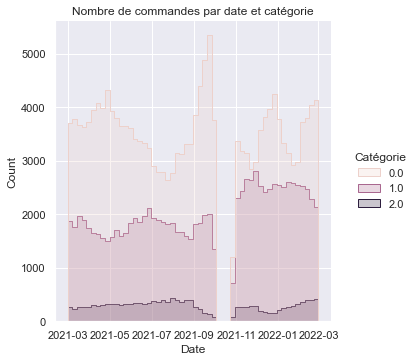

In [77]:
sns.displot(
    b2c, 
    x="Date",
    hue='Catégorie', 
    bins=54, # (1 classe = 1 semaine)
    element='step'
    )
plt.title('Nombre de commandes par date et catégorie')
plt.show()

# --> Catégorie 0 : pic d'achat au mois de septembre, comme chez les professionnels
# --> Catégorie 1 : pic d'achat autour des fêtes de fin d'année

## Catégories
- la catégorie 0 représente 60% des transactions
- la catégorie 2 ne réprésente que 5% des transactions
- les catégories correspondent à 3 classes de prix ordonnées

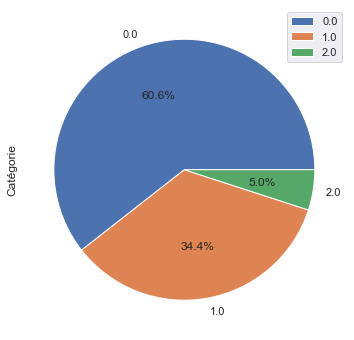

In [78]:
b2c['Catégorie'].value_counts(normalize=True).plot(
    kind='pie',
    legend=True,
    autopct='%1.1f%%'
)
plt.show()

### Par âge

In [79]:
indicateurs_bivaries(data, 'Catégorie', 'Âge')

Modalité : 0.0 (fréquence : 60.5 %)

Indicateurs de position : 
Mode(s) : [40] (fréquence : 8.9 %) 
Moyenne : 41.9 
Médiane : 40.0 
1er quartile : 34.0 
3ème quartile : 47.0 
Indicateurs de dispersion : 
Minimum : 16 
Maximum : 91 
Étendue : 75 
Variance : 125.6 
Écart-type :  11.2 
Coeff. de variation : 0.3 
Skewness : 1.0 ( distribution étalée à droite ) 
Kurtosis : 1.8 ( distribution moins aplatie que la normale gaussienne )


Modalité : 2.0 (fréquence : 5.2 %)

Indicateurs de position : 
Mode(s) : [16] (fréquence : 16.6 %) 
Moyenne : 23.7 
Médiane : 21.0 
1er quartile : 18.0 
3ème quartile : 26.0 
Indicateurs de dispersion : 
Minimum : 16 
Maximum : 90 
Étendue : 74 
Variance : 90.1 
Écart-type :  9.5 
Coeff. de variation : 0.4 
Skewness : 3.0 ( distribution étalée à droite ) 
Kurtosis : 11.0 ( distribution moins aplatie que la normale gaussienne )


Modalité : 1.0 (fréquence : 34.3 %)

Indicateurs de position : 
Mode(s) : [40] (fréquence : 4.6 %) 
Moyenne : 45.7 
Médiane : 45.0 
1

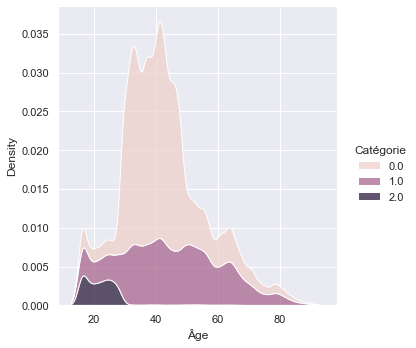

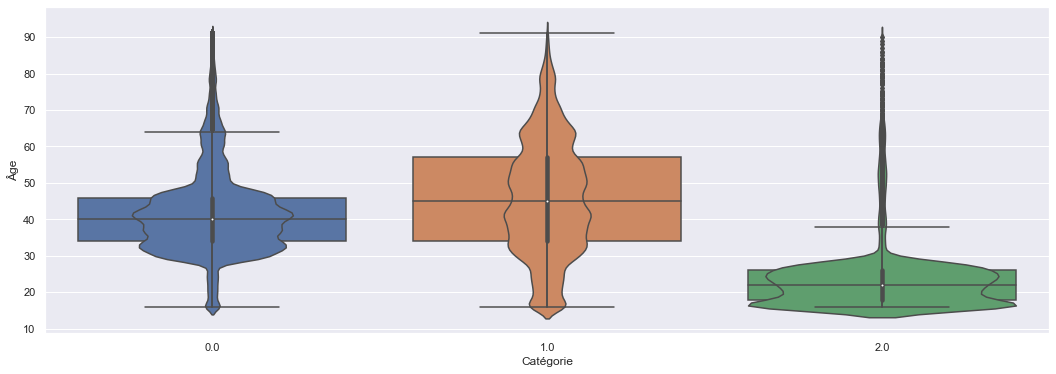

In [80]:
# Par âge
sns.displot(data=b2c, x='Âge', hue='Catégorie', kind='kde', multiple='stack', fill=True)
plt.show()

sns.boxplot(data=b2c, y='Âge', x='Catégorie')
sns.violinplot(data=b2c, y='Âge', x='Catégorie', showfliers=False)
plt.show()

# --> Les catégories 0 et 1 ont les mêmes formes d'histogramme, excepté une plus forte densité entre 30 et 50 ans
# --> La catégorie 2 est majoritairement achetée par des clients de moins de 30 ans

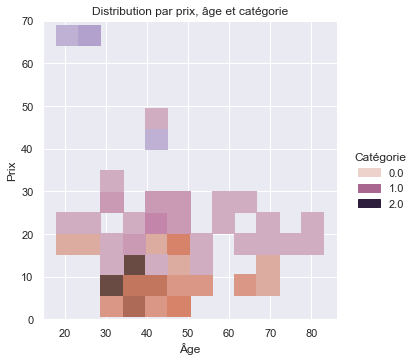

c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:1181: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


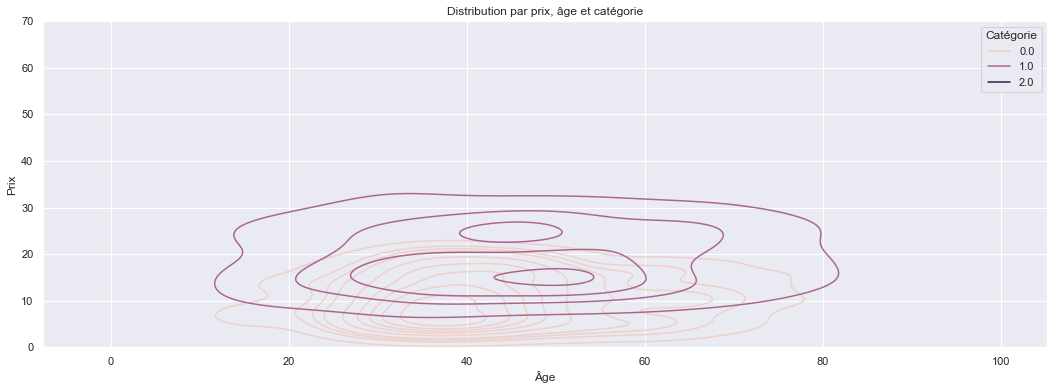

In [81]:
sns.displot(
    data=b2c.sample(100), 
    y='Prix', 
    x='Âge', 
    hue='Catégorie'
)
plt.title('Distribution par prix, âge et catégorie')
plt.ylim(0, 70)
plt.show()

sns.kdeplot(
    data=b2c.sample(500), 
    y='Prix', 
    x='Âge', 
    hue='Catégorie'
)
plt.title('Distribution par prix, âge et catégorie')
plt.ylim(0, 70)
plt.show()

Sample 1 :


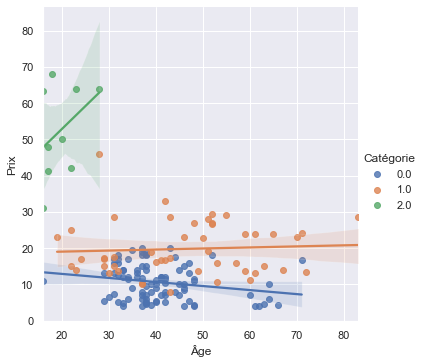

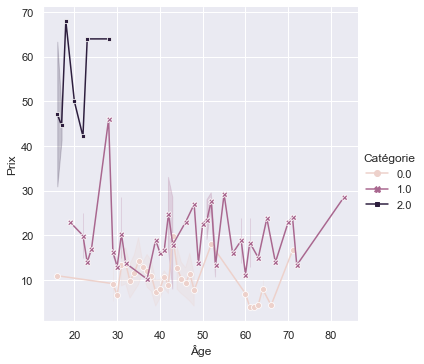

Sample 2 :


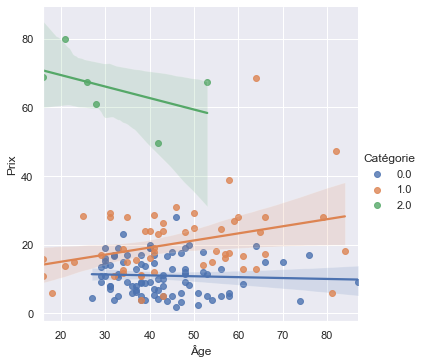

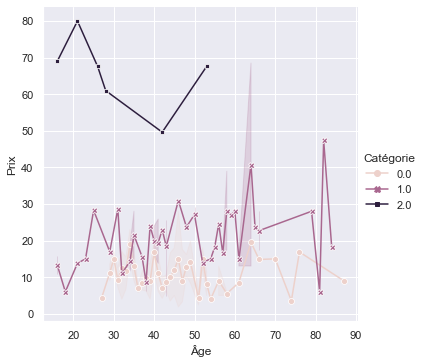

In [82]:
for i in range(0,2):
    sample = b2c.sample(random.randint(150, 150))
    print('Sample', i+1, ':')
    sns.lmplot(data=sample, x='Âge', y='Prix', hue='Catégorie')
    plt.show()
    sns.relplot(
        data=sample, x='Âge', y='Prix', hue='Catégorie', style='Catégorie', 
        kind='line', markers=True, dashes=False
    )
    plt.show()

### Par prix

In [83]:
indicateurs_bivaries(data, 'Catégorie', 'Prix')

Modalité : 0.0 (fréquence : 60.5 %)

Indicateurs de position : 
Mode(s) : [4.99] (fréquence : 4.4 %) 
Moyenne : 10.6 
Médiane : 9.99 
1er quartile : 6.3 
3ème quartile : 14.4 
Indicateurs de dispersion : 
Minimum : 0.62 
Maximum : 40.99 
Étendue : 40.4 
Variance : 24.3 
Écart-type :  4.9 
Coeff. de variation : 0.5 
Skewness : 0.4 ( distribution étalée à droite ) 
Kurtosis : -0.4 ( distribution plus aplatie que la normale gaussienne )


Modalité : 2.0 (fréquence : 5.2 %)

Indicateurs de position : 
Mode(s) : [68.99] (fréquence : 6.1 %) 
Moyenne : 75.3 
Médiane : 62.83 
1er quartile : 54.0 
3ème quartile : 71.2 
Indicateurs de dispersion : 
Minimum : 30.99 
Maximum : 300.0 
Étendue : 269.0 
Variance : 1535.7 
Écart-type :  39.2 
Coeff. de variation : 0.5 
Skewness : 2.3 ( distribution étalée à droite ) 
Kurtosis : 5.5 ( distribution moins aplatie que la normale gaussienne )


Modalité : 1.0 (fréquence : 34.3 %)

Indicateurs de position : 
Mode(s) : [15.99] (fréquence : 4.4 %) 
Moyenne : 

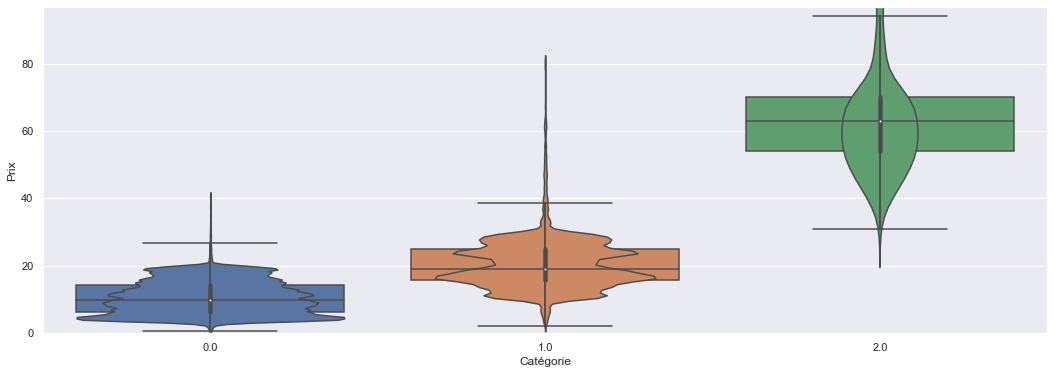

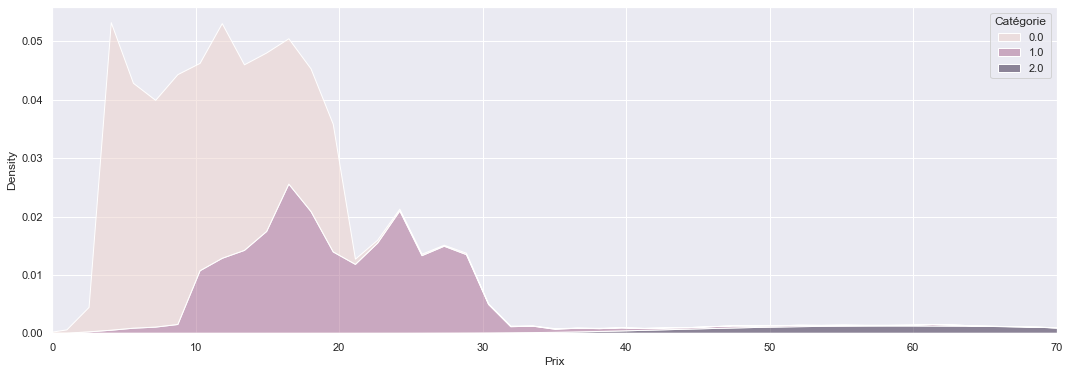

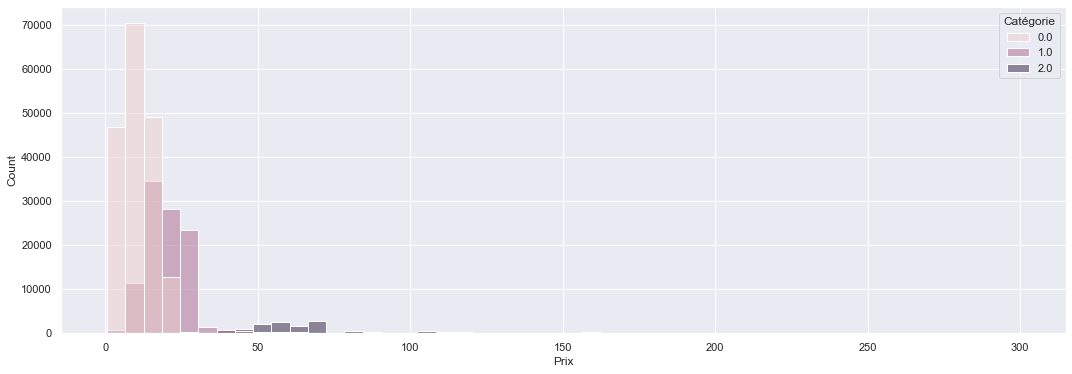

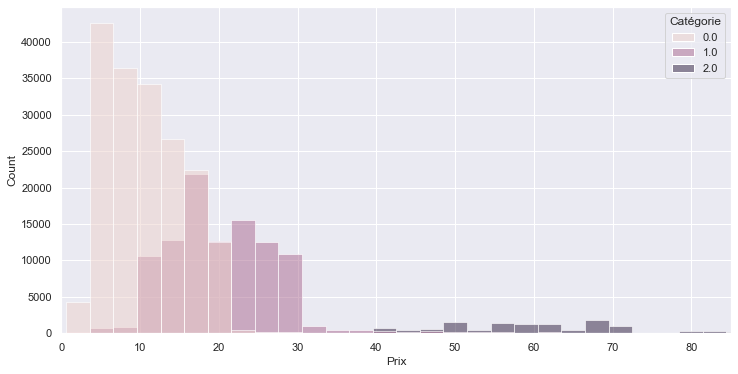

In [84]:
# Par prix
sns.violinplot(data=b2c, x='Catégorie', y='Prix', showfliers=False)
sns.boxplot(data=b2c, x='Catégorie', y='Prix', showfliers=False)
#sns.set(rc={'figure.figsize':(12,6)})
plt.ylim([0,b2c['Prix'].quantile(.991)])
plt.show()

a = sns.kdeplot(data=b2c, x='Prix', hue='Catégorie', multiple='stack', alpha=.5)
a.set(xlim=(0, 70))
plt.show(a)

sns.histplot(data=b2c, x='Prix', hue='Catégorie', bins=50)
sns.set(rc={'figure.figsize':(12,6)})
plt.show()

sns.histplot(data=b2c, x='Prix', hue='Catégorie', bins=100)
sns.set(rc={'figure.figsize':(6,6)})
plt.xlim([0,b2c['Prix'].quantile(.99)])
plt.show()

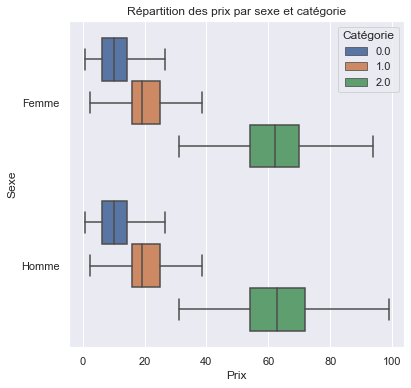

In [85]:
# Par sexe et prix
sns.boxplot(data=data, x='Prix', y='Sexe', hue='Catégorie', showfliers=False)
plt.title('Répartition des prix par sexe et catégorie')
plt.show()

# --> La catégorie semble corrélée au prix

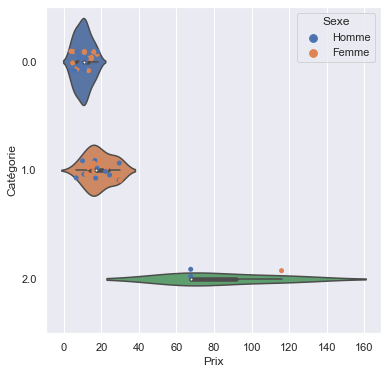

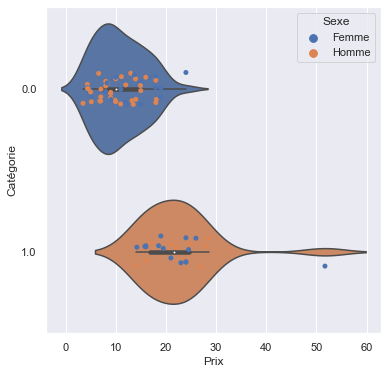

In [86]:
for i in range(0,2):
    sample = b2c.sample(random.randint(50, 150))
    g = sns.stripplot(y='Catégorie', x='Prix', hue='Sexe', data=sample, orient='h')
    g = sns.violinplot(y='Catégorie', x='Prix', data=sample, orient='h')
    plt.show(g)
    
    import random

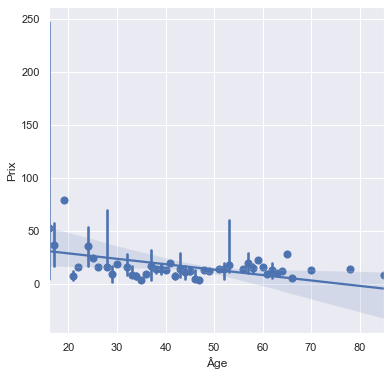

In [87]:
# Régression linéaire
sns.regplot(
    data=b2c.sample(100), 
    x='Âge',
    y='Prix',
    x_estimator=np.median)

plt.show()

# --> La catégorie est corrélée au prix

### Par date

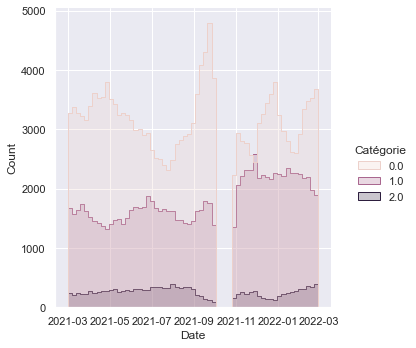

In [88]:
# Par date
sns.displot(data=b2c, x='Date', hue='Catégorie', element='step')
plt.show()

## Tests
Hypothèses :
- *Catégorie* et *Âge* seraient corrélés

In [89]:
# Tests de normalité
def tests_normalite(data):
    
    tests = pd.DataFrame([
        [shapiro, 'Shapiro-Wilk Test'],
        [normaltest, 'D’Agostino’s K^2 Test']
    ])
    
    for i in range(0, len(tests)):
    
        stat, p = tests.loc[i,0](data)
        print(style.bold + tests.loc[i,1] + style.end)
        print('Stat = %.3f, p = %.3f' % (stat, p * 100), '%')   
        if p > 0.05:
            print(
                style.bold + style.green +
                'Probablement une distribution normale : h0 acceptée'
                + style.end)
        else:
            print(
                style.bold + style.red +
                'Probablement pas une distribution normale : h0 rejetée'
                + style.end)
        print('\n')
      
    print(style.bold + 'Anderson-Darling Test' + style.end)
    result = anderson(data)
    print('Stat = %.3f' % (result.statistic))
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < cv:
            print('Probably Gaussian at the %.1f%% level' % (sl))
        else:
            print('Probably not Gaussian at the %.1f%% level' % (sl))
    
    sns.histplot(data, bins=25)
    plt.show()
    qqplot(np.array(data), line='s')
    plt.show()

In [90]:
# Tests de corrélation
def tests_correlation(data1, data2):
    
    tests = pd.DataFrame([
        # Pearson’s Correlation Coefficient
        [pearsonr, 'Pearson\'s Correlation Test (same variance)'],
         # Spearman’s Rank Correlation + Kendall’s Rank Correlation
        [spearmanr, 'Spearman’s Rank Correlation (monotonic relationship)'],
        [kendalltau, 'Kendall’s Rank Correlation (monotonic relationship)']])
    
    for i in range(0, len(tests)):   
        stat, p = tests.loc[i,0](data1, data2)
        print(tests.loc[i,1])
        print('Stat = %.3f, p = %.1f' % (stat, p * 100), '%')   
        if p > 0.05:
            print(
                style.bold + style.red +
                'Probablement indépendant : h0 acceptée' + style.end)
        else:
            print(
                style.bold + style.green +
                'Probablement dépendant : h0 rejetée' + style.end)
        print('\n')

    # Chi-Squared Test 
    print('Chi-Squared Test (two categorial)')
    table = [data1, data2]
    stat, p, dof, expected = chi2_contingency(table)
    print('Stat = %.3f, p = %.1f' % (stat, p * 100), '%')
    if p > 0.05:
        print(
            style.bold + style.red +
            'Probablement indépendant : h0 acceptée' + style.end)
    else:
        print(
            style.bold + style.green +
            'Probablement dépendant : h0 rejetée' + style.end)

### *Âge* + *Prix*

In [91]:
tests_correlation(b2c['Âge'], b2c['Prix'])

# --> h0 rejetée pour les tous les tests : 'Âge' et 'Prix' sont probablement corrélées

Pearson's Correlation Test (same variance)
Stat = -0.197, p = 0.0 %
Probablement dépendant : h0 rejetée


Spearman’s Rank Correlation (monotonic relationship)
Stat = -0.046, p = 0.0 %
Probablement dépendant : h0 rejetée


Kendall’s Rank Correlation (monotonic relationship)
Stat = -0.028, p = 0.0 %
Probablement dépendant : h0 rejetée


Chi-Squared Test (two categorial)
Stat = 2721137.723, p = 0.0 %
Probablement dépendant : h0 rejetée


### *Catégorie* + *Prix*

In [92]:
# Tests de corrélation entre 'Catégorie' et 'Prix'
tests_correlation(data['Catégorie'], data['Prix'])

# --> Le test de Pearson indique une corrélation
# --> Les tests de Spearman et Kendall inquent monotonic relationship
# --> Le Chi2 confirme que les deux variables ne sont pas catégorielles

Pearson's Correlation Test (same variance)
Stat = 0.669, p = 0.0 %
Probablement dépendant : h0 rejetée


Spearman’s Rank Correlation (monotonic relationship)
Stat = 0.686, p = 0.0 %
Probablement dépendant : h0 rejetée


Kendall’s Rank Correlation (monotonic relationship)
Stat = 0.574, p = 0.0 %
Probablement dépendant : h0 rejetée


Chi-Squared Test (two categorial)
Stat = 129092.384, p = 100.0 %
Probablement indépendant : h0 acceptée


In [93]:
# Test d'ANOVA sur 'Catégorie' et 'Prix'
model = smf.ols('Prix ~ Catégorie', data = data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(
    style.bold + 'P-value :' + style.end, anova_table['PR(>F)'][0],
    style.bold + '\n\n\nANOVA table : \n' + style.end,
    anova_table,
    style.bold + '\n\n\nModel Summary : \n' + style.end,
    model.summary()
)

P-value : 0.0 


ANOVA table : 
                  sum_sq        df              F  PR(>F)
Catégorie  4.546477e+07       1.0  258235.713222     0.0
Residual   5.615460e+07  318953.0            NaN     NaN 


Model Summary : 
                             OLS Regression Results                            
Dep. Variable:                   Prix   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                 2.582e+05
Date:                Sun, 01 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:27:21   Log-Likelihood:            -1.2772e+06
No. Observations:              318955   AIC:                         2.554e+06
Df Residuals:                  318953   BIC:                         2.554e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                           

Shapiro-Wilk Test
Stat = 0.623, p = 0.000 %
Probablement pas une distribution normale : h0 rejetée


D’Agostino’s K^2 Test
Stat = 374304.859, p = 0.000 %
Probablement pas une distribution normale : h0 rejetée


Anderson-Darling Test
Stat = 15982.919
Probably not Gaussian at the 15.0% level
Probably not Gaussian at the 10.0% level
Probably not Gaussian at the 5.0% level
Probably not Gaussian at the 2.5% level
Probably not Gaussian at the 1.0% level


c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


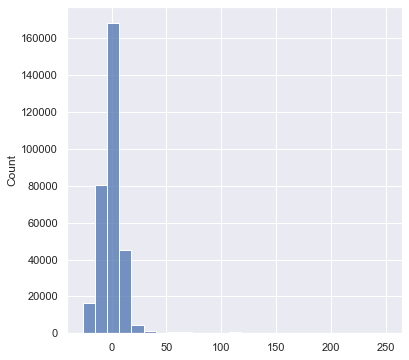

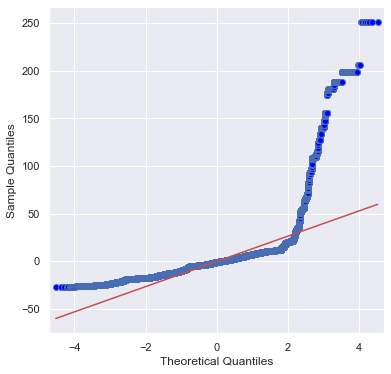

In [94]:
# --> Condition de l'ANOVA : une distribution normale
# --> Vérification de la normalité des résidus
tests_normalite(model.resid)

Distribution après boxcox


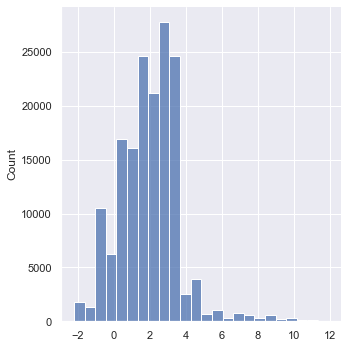

In [95]:
# Distribution des résidus après boxcox
print('Distribution après boxcox')
sns.displot(boxcox1p(model.resid, .25), bins=24)
plt.show()

c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:1617: RuntimeWarning: invalid value encountered in sign
  term2 = np.sign(denom) * np.where(denom == 0.0, np.nan,
c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:1889: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:1977: RuntimeWarning: invalid value encountered in less_equal
  

Shapiro-Wilk Test
Stat = nan, p = 100.000 %
Probablement une distribution normale : h0 acceptée


D’Agostino’s K^2 Test
Stat = nan, p = nan %
Probablement pas une distribution normale : h0 rejetée


Anderson-Darling Test
Stat = nan
Probably not Gaussian at the 15.0% level
Probably not Gaussian at the 10.0% level
Probably not Gaussian at the 5.0% level
Probably not Gaussian at the 2.5% level
Probably not Gaussian at the 1.0% level


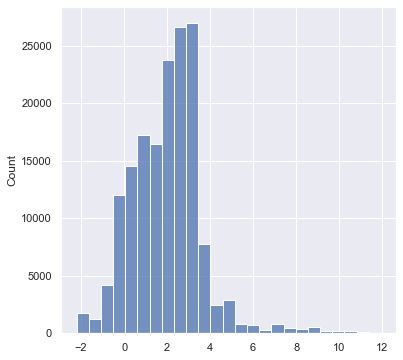

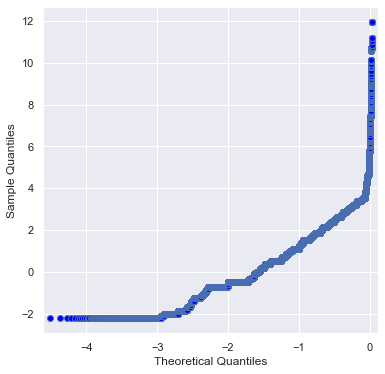

In [96]:
# --> Tests de normalité sur les résidus après boxcox
tests_normalite(boxcox1p(model.resid, .25))

# --> Distribution normale d'après le test de Shapiro
# --> La condition de l'ANOVA est remplie

### *Catégorie* + *Âge*

In [97]:
indicateurs_bivaries(b2c, 'Catégorie', 'Âge')

Modalité : 0.0 (fréquence : 60.6 %)

Indicateurs de position : 
Mode(s) : [32] (fréquence : 4.9 %) 
Moyenne : 41.8 
Médiane : 40.0 
1er quartile : 34.0 
3ème quartile : 46.0 
Indicateurs de dispersion : 
Minimum : 16 
Maximum : 91 
Étendue : 75 
Variance : 132.6 
Écart-type :  11.5 
Coeff. de variation : 0.3 
Skewness : 1.0 ( distribution étalée à droite ) 
Kurtosis : 1.6 ( distribution moins aplatie que la normale gaussienne )


Modalité : 2.0 (fréquence : 5.0 %)

Indicateurs de position : 
Mode(s) : [16] (fréquence : 18.5 %) 
Moyenne : 23.7 
Médiane : 22.0 
1er quartile : 18.0 
3ème quartile : 26.0 
Indicateurs de dispersion : 
Minimum : 16 
Maximum : 90 
Étendue : 74 
Variance : 92.4 
Écart-type :  9.6 
Coeff. de variation : 0.4 
Skewness : 3.0 ( distribution étalée à droite ) 
Kurtosis : 11.1 ( distribution moins aplatie que la normale gaussienne )


Modalité : 1.0 (fréquence : 34.4 %)

Indicateurs de position : 
Mode(s) : [41] (fréquence : 2.8 %) 
Moyenne : 45.8 
Médiane : 45.0 
1

In [98]:
tests_correlation(data['Âge'], data['Catégorie'])

Pearson's Correlation Test (same variance)
Stat = -0.094, p = 0.0 %
Probablement dépendant : h0 rejetée


Spearman’s Rank Correlation (monotonic relationship)
Stat = -0.032, p = 0.0 %
Probablement dépendant : h0 rejetée


Kendall’s Rank Correlation (monotonic relationship)
Stat = -0.019, p = 0.0 %
Probablement dépendant : h0 rejetée


Chi-Squared Test (two categorial)
Stat = 384253.589, p = 0.0 %
Probablement dépendant : h0 rejetée


In [99]:
# Test d'ANOVA sur 'Catégorie' et 'Âge'
model = smf.ols('Âge ~ Catégorie', data = data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(
    style.bold + 'P-value :' + style.end, anova_table['PR(>F)'][0],
    style.bold + '\n\n\nANOVA table : \n' + style.end,
    anova_table,
    style.bold + '\n\n\nModel Summary : \n' + style.end,
    model.summary()
)

# --> Probabilité forte que h0 soit fausse
# --> Les 2 variables seraient dépendantes

P-value : 0.0 


ANOVA table : 
                  sum_sq        df            F  PR(>F)
Catégorie  5.211408e+05       1.0  2841.599214     0.0
Residual   5.849503e+07  318953.0          NaN     NaN 


Model Summary : 
                             OLS Regression Results                            
Dep. Variable:                    Âge   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2842.
Date:                Sun, 01 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:27:24   Log-Likelihood:            -1.2837e+06
No. Observations:              318955   AIC:                         2.567e+06
Df Residuals:                  318953   BIC:                         2.567e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                 

Shapiro-Wilk Test
Stat = 0.967, p = 0.000 %
Probablement pas une distribution normale : h0 rejetée


D’Agostino’s K^2 Test
Stat = 22756.962, p = 0.000 %
Probablement pas une distribution normale : h0 rejetée


Anderson-Darling Test
Stat = 3181.520
Probably not Gaussian at the 15.0% level
Probably not Gaussian at the 10.0% level
Probably not Gaussian at the 5.0% level
Probably not Gaussian at the 2.5% level
Probably not Gaussian at the 1.0% level


c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


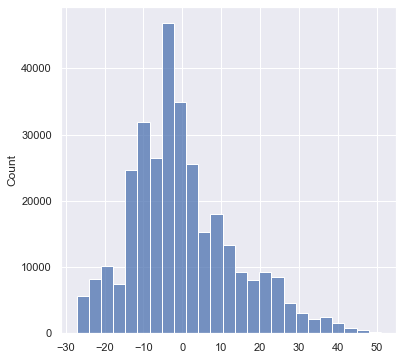

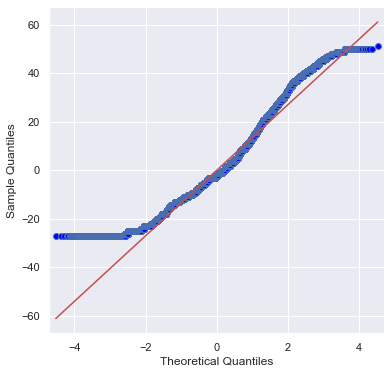

In [100]:
# --> Condition de l'ANOVA : une distribution normale
# --> Vérification de la normalité des résidus
tests_normalite(model.resid)

# Les résidus n'ont pas une distribution normale
# La condition d'ANOVA n'est pas remplie

Distribution après boxcox


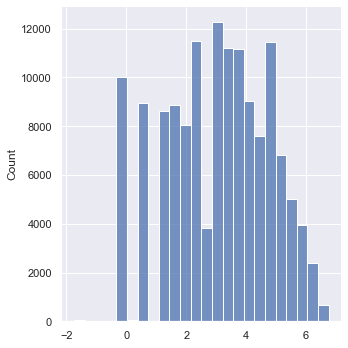

In [101]:
# Essai avec un log sur les échantillons
# Distribution des résidus après boxcox
print('Distribution après boxcox')
sns.displot(boxcox1p(model.resid, .25), bins=24)
plt.show()

In [ ]:
# --> Tests de normalité sur les résidus après boxcox
tests_normalite(boxcox1p(model.resid, .25))

# --> Distribution normale d'après le test de Shapiro
# --> La condition de l'ANOVA est remplie : Catégorie et Âge sont probablement corrélés

# Conclusion

Résultats
- ...
- ...
- ...

Interprétations
- ...
- ...

Recommandations
- ...